This notebook will implement changing lora settings and separate dataloader

In [1]:
# !pip install torch==2.1.1 torchaudio torchvision tqdm==4.66.1 accelerate==0.24.1 biopython==1.81 numpy==1.26.2 pandas==2.1.3 \
# transformers==4.35.2 datasets==2.15.0 scikit-learn==1.3.2 umap-learn==0.5.5 sentencepiece==0.1.99 seaborn==0.13.0 scipy==1.11.4 \
# matplotlib==3.8.2 evaluate==0.4.1 deepspeed==0.12.3

In [2]:
# try with UMAP

In [1]:
import os.path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader

import re
import numpy as np
import pandas as pd
import copy

import transformers, datasets
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.models.t5.modeling_t5 import T5Config, T5PreTrainedModel, T5Stack
from transformers.utils.model_parallel_utils import assert_device_map, get_device_map
from transformers import T5EncoderModel, T5Tokenizer
from transformers import TrainingArguments, Trainer, set_seed

from evaluate import load
from datasets import Dataset

from tqdm import tqdm
import random

from scipy import stats
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
#!pip install umap-learn
import umap

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Torch version: ",torch.__version__)
print("Cuda version: ",torch.version.cuda)
print("Numpy version: ",np.__version__)
print("Pandas version: ",pd.__version__)
print("Transformers version: ",transformers.__version__)
print("Datasets version: ",datasets.__version__)

Torch version:  2.1.1+cu121
Cuda version:  12.1
Numpy version:  1.26.4
Pandas version:  2.2.2
Transformers version:  4.35.2
Datasets version:  2.19.1


In [3]:
from Bio import SeqIO
import pandas as pd

sequences = []

local_fasta_path = '../src/input_datasets/train_Pos_Neg_ST.fasta'

# Load FASTA file using Biopython
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

local_fasta_path = '../src/input_datasets/train_Pos_Neg_Y.fasta'

for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

# Create dataframe
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display the dataframe
df.head(5)


,name,sequence,label
0,sp|P24928|RPB1_HUMAN%1775%1791,NYTPTSPNYSPTSPSYSPTSPSYSPTSPSYSPS,1
1,sp|P05787|K2C8_HUMAN%58%74,SGMGGITAVTVNQSLLSPLVLEVDPNIQAVRTQ,1
2,sp|Q14832|GRM3_HUMAN%829%845,QPQKNVVTHRLHLNRFSVSGTGTTYSQSSASTY,1
3,sp|P01106|MYC_HUMAN%46%62,SEDIWKKFELLPTPPLSPSRRSGLCSPSYVAVT,1
4,sp|Q92736|RYR2_HUMAN%2792%2808,TREGDSMALYNRTRRISQTSQVSVDAAHGYSPR,1


In [6]:
# # Function to get the middle character
# def get_middle_char(sequence):
#     chars = list(sequence)
#     middle_index = len(chars) // 2
#     return chars[middle_index]

# # Apply the function to get the middle characters
# df['middle_char'] = df['sequence'].apply(get_middle_char)

In [7]:
# # Function to count 'S', 'T', 'Y' in a sequence
# def count_chars(sequence, char):
#     return sequence.count(char)

# # Count the occurrences of 'S', 'T', and 'Y' in the sequences
# df['count_S'] = df['middle_char'].apply(lambda seq: count_chars(seq, 'S'))
# df['count_T'] = df['middle_char'].apply(lambda seq: count_chars(seq, 'T'))
# df['count_Y'] = df['middle_char'].apply(lambda seq: count_chars(seq, 'Y'))

# # Sum the counts to get the total occurrences in the DataFrame
# total_S = df['count_S'].sum()
# total_T = df['count_T'].sum()
# total_Y = df['count_Y'].sum()

# print(f"Total number of 'S': {total_S}")
# print(f"Total number of 'T': {total_T}")
# print(f"Total number of 'Y': {total_Y}")

In [8]:
# # Group by label and sum the counts
# grouped_counts = df.groupby('label')[['count_S', 'count_T', 'count_Y']].sum().reset_index()

# # Display the grouped counts
# print(grouped_counts)

In [9]:
# # Separate the DataFrame by middle character
# df_S = df[df['middle_char'] == 'S']
# df_T = df[df['middle_char'] == 'T']
# df_Y = df[df['middle_char'] == 'Y']

# # Separate each subset by label
# df_S_0 = df_S[df_S['label'] == 0]
# df_S_1 = df_S[df_S['label'] == 1]
# df_T_0 = df_T[df_T['label'] == 0]
# df_T_1 = df_T[df_T['label'] == 1]
# df_Y_0 = df_Y[df_Y['label'] == 0]
# df_Y_1 = df_Y[df_Y['label'] == 1]


In [10]:
# from sklearn.utils import resample
# # Desired number of samples per group
# n_samples_S = 500
# n_sampple_T = 300
# n_sampple_Y = 200
# # Perform stratified sampling
# df_S_0_resampled = resample(df_S_0, replace=False, n_samples=n_samples_S, random_state=42)
# df_S_1_resampled = resample(df_S_1, replace=False, n_samples=n_samples_S, random_state=42)
# df_T_0_resampled = resample(df_T_0, replace=True, n_samples=n_sampple_T, random_state=42)
# df_T_1_resampled = resample(df_T_1, replace=True, n_samples=n_sampple_T, random_state=42)
# df_Y_0_resampled = resample(df_Y_0, replace=True, n_samples=n_sampple_Y, random_state=42)
# df_Y_1_resampled = resample(df_Y_1, replace=True, n_samples=n_sampple_Y, random_state=42)



In [11]:
# # Combine the resampled subsets
# balanced_df = pd.concat([
#     df_S_0_resampled, df_S_1_resampled,
#     df_T_0_resampled, df_T_1_resampled,
#     df_Y_0_resampled, df_Y_1_resampled
# ])

# # Shuffle the combined DataFrame
# balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# print("Balanced DataFrame:")
# print(balanced_df)


In [12]:
# from sklearn.model_selection import train_test_split

# # Split the dataset into training and validation sets
# my_train, my_valid = train_test_split(
#     balanced_df, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=balanced_df[['label', 'middle_char']]
# )

# my_train=my_train[["sequence", "label"]]
# my_valid=my_valid[["sequence","label"]]


# # Print the first 5 rows of the training set
# print("Training Set:")
# print(my_train.shape)

# # Print the first 5 rows of the validation set
# print("\nValidation Set:")
# print(my_valid.shape)

In [4]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
my_train, my_valid = train_test_split(df, test_size=0.2, random_state=42)

my_train=my_train[["sequence", "label"]]
my_valid=my_valid[["sequence","label"]]


# Print the first 5 rows of the training set
print("Training Set:")
print(my_train.shape)

# Print the first 5 rows of the validation set
print("\nValidation Set:")
print(my_valid.shape)

Training Set:
(1584, 2)

Validation Set:
(396, 2)


In [5]:
# Modifies an existing transformer and introduce the LoRA layers

class LoRAConfig:
    def __init__(self, lora_rank=8, lora_init_scale=0.01, lora_scaling_rank=2):
        self.lora_rank = lora_rank
        self.lora_init_scale = lora_init_scale
        self.lora_modules = ".*SelfAttention|.*EncDecAttention"
        self.lora_layers = "q|k|v|o"
        self.trainable_param_names = ".*layer_norm.*|.*lora_[ab].*"
        self.lora_scaling_rank = lora_scaling_rank
        # lora_modules and lora_layers are specified with regular expressions
        # see https://www.w3schools.com/python/python_regex.asp for reference
        
class LoRALinear(nn.Module):
    def __init__(self, linear_layer, rank, scaling_rank, init_scale):
        super().__init__()
        self.in_features = linear_layer.in_features
        self.out_features = linear_layer.out_features
        self.rank = rank
        self.scaling_rank = scaling_rank
        self.weight = linear_layer.weight
        self.bias = linear_layer.bias
        if self.rank > 0:
            self.lora_a = nn.Parameter(torch.randn(rank, linear_layer.in_features) * init_scale)
            if init_scale < 0:
                self.lora_b = nn.Parameter(torch.randn(linear_layer.out_features, rank) * init_scale)
            else:
                self.lora_b = nn.Parameter(torch.zeros(linear_layer.out_features, rank))
        if self.scaling_rank:
            self.multi_lora_a = nn.Parameter(
                torch.ones(self.scaling_rank, linear_layer.in_features)
                + torch.randn(self.scaling_rank, linear_layer.in_features) * init_scale
            )
            if init_scale < 0:
                self.multi_lora_b = nn.Parameter(
                    torch.ones(linear_layer.out_features, self.scaling_rank)
                    + torch.randn(linear_layer.out_features, self.scaling_rank) * init_scale
                )
            else:
                self.multi_lora_b = nn.Parameter(torch.ones(linear_layer.out_features, self.scaling_rank))

    def forward(self, input):
        if self.scaling_rank == 1 and self.rank == 0:
            # parsimonious implementation for ia3 and lora scaling
            if self.multi_lora_a.requires_grad:
                hidden = F.linear((input * self.multi_lora_a.flatten()), self.weight, self.bias)
            else:
                hidden = F.linear(input, self.weight, self.bias)
            if self.multi_lora_b.requires_grad:
                hidden = hidden * self.multi_lora_b.flatten()
            return hidden
        else:
            # general implementation for lora (adding and scaling)
            weight = self.weight
            if self.scaling_rank:
                weight = weight * torch.matmul(self.multi_lora_b, self.multi_lora_a) / self.scaling_rank
            if self.rank:
                weight = weight + torch.matmul(self.lora_b, self.lora_a) / self.rank
            return F.linear(input, weight, self.bias)

    def extra_repr(self):
        return "in_features={}, out_features={}, bias={}, rank={}, scaling_rank={}".format(
            self.in_features, self.out_features, self.bias is not None, self.rank, self.scaling_rank
        )


def modify_with_lora(transformer, config):
    for m_name, module in dict(transformer.named_modules()).items():
        if re.fullmatch(config.lora_modules, m_name):
            for c_name, layer in dict(module.named_children()).items():
                if re.fullmatch(config.lora_layers, c_name):
                    assert isinstance(
                        layer, nn.Linear
                    ), f"LoRA can only be applied to torch.nn.Linear, but {layer} is {type(layer)}."
                    setattr(
                        module,
                        c_name,
                        LoRALinear(layer, config.lora_rank, config.lora_scaling_rank, config.lora_init_scale),
                    )
    return transformer

In [5]:
class DoRAConfig:
    def __init__(self, dora_rank=8, dora_init_scale=0.01):
        self.dora_rank = dora_rank
        self.dora_init_scale = dora_init_scale
        self.dora_modules = ".*SelfAttention|.*EncDecAttention"
        self.dora_layers = "q|k|v|o"
        self.trainable_param_names = ".*layer_norm.*|.*dora_diag.*"

class DoRALinear(nn.Module):
    def __init__(self, linear_layer, rank, init_scale):
        super().__init__()
        self.in_features = linear_layer.in_features
        self.out_features = linear_layer.out_features
        self.rank = rank
        self.weight = linear_layer.weight
        self.bias = linear_layer.bias
        if self.rank > 0:
            self.dora_diag = nn.Parameter(torch.randn(min(self.in_features, self.out_features)) * init_scale)

    def forward(self, input):
        weight = self.weight
        if self.rank:
            diag_matrix = torch.diag(self.dora_diag)  # Create a diagonal matrix from the parameters
            diag_matrix_padded = torch.zeros_like(weight)
            diag_matrix_padded[:diag_matrix.shape[0], :diag_matrix.shape[1]] = diag_matrix
            weight = weight + diag_matrix_padded  # Ensure correct size
        return F.linear(input, weight, self.bias)

    def extra_repr(self):
        return "in_features={}, out_features={}, bias={}, rank={}".format(
            self.in_features, self.out_features, self.bias is not None, self.rank
        )


def modify_with_dora(transformer, config):
    for m_name, module in dict(transformer.named_modules()).items():
        if re.fullmatch(config.dora_modules, m_name):
            for c_name, layer in dict(module.named_children()).items():
                if re.fullmatch(config.dora_layers, c_name):
                    assert isinstance(
                        layer, nn.Linear
                    ), f"DoRA can only be applied to torch.nn.Linear, but {layer} is {type(layer)}."
                    setattr(
                        module,
                        c_name,
                        DoRALinear(layer, config.dora_rank, config.dora_init_scale),
                    )
    return transformer



In [6]:
class ClassConfig:
    def __init__(self, dropout=0.7, num_labels=2):
        self.dropout_rate = dropout
        self.num_labels = num_labels

class T5EncoderClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config, class_config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(class_config.dropout_rate)
        self.out_proj = nn.Linear(config.hidden_size, class_config.num_labels)
        
        # Trainable emphasis factor
        self.emphasis_factor = nn.Parameter(torch.tensor(1.0))
        
    def forward(self, hidden_states):
        seq_length = hidden_states.size(1)
        middle_idx = seq_length // 2
        middle_embedding = hidden_states[:, middle_idx, :]

        # Apply trainable emphasis factor
        emphasized_middle_embedding = middle_embedding * self.emphasis_factor

        # Combine with the average embedding
        average_embedding = torch.mean(hidden_states, dim=1)
        combined_embedding = emphasized_middle_embedding + average_embedding

        x = self.dropout(combined_embedding)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        logits = self.out_proj(x)
        return logits

    # def forward(self, hidden_states):

    #     hidden_states =  torch.mean(hidden_states,dim=1)  # avg embedding

    #     hidden_states = self.dropout(hidden_states)
    #     hidden_states = self.dense(hidden_states)
    #     hidden_states = torch.tanh(hidden_states)
    #     hidden_states = self.dropout(hidden_states)
    #     hidden_states = self.out_proj(hidden_states)
    #     return hidden_states
    
    # def forward(self, hidden_states):
    #     # Original sequence length and middle index
    #     seq_length = hidden_states.size(1)
    #     middle_idx = seq_length // 2

    #     # Extract the middle embedding vector
    #     middle_embedding = hidden_states[:, middle_idx, :]

    #     # Amplify the influence of the middle embedding
    #     amplified_middle_embedding = middle_embedding * 2

    #     # Combine with average to retain context
    #     average_embedding = torch.mean(hidden_states, dim=1)
    #     combined_embedding = 0.5 * amplified_middle_embedding + 0.5 * average_embedding

    #     # Classification layers
    #     x = self.dropout(combined_embedding)
    #     x = self.dense(x)
    #     x = torch.tanh(x)
    #     x = self.dropout(x)
    #     logits = self.out_proj(x)
    #     return logits


class T5EncoderForSimpleSequenceClassification(T5PreTrainedModel):

    def __init__(self, config: T5Config, class_config):
        super().__init__(config)
        self.num_labels = class_config.num_labels
        self.config = config

        self.shared = nn.Embedding(config.vocab_size, config.d_model)

        encoder_config = copy.deepcopy(config)
        encoder_config.use_cache = False
        encoder_config.is_encoder_decoder = False
        self.encoder = T5Stack(encoder_config, self.shared)

        self.dropout = nn.Dropout(class_config.dropout_rate) 
        self.classifier = T5EncoderClassificationHead(config, class_config)

        # Initialize weights and apply final processing
        self.post_init()

        # Model parallel
        self.model_parallel = False
        self.device_map = None

    def parallelize(self, device_map=None):
        self.device_map = (
            get_device_map(len(self.encoder.block), range(torch.cuda.device_count()))
            if device_map is None
            else device_map
        )
        assert_device_map(self.device_map, len(self.encoder.block))
        self.encoder.parallelize(self.device_map)
        self.classifier = self.classifier.to(self.encoder.first_device)
        self.model_parallel = True

    def deparallelize(self):
        self.encoder.deparallelize()
        self.encoder = self.encoder.to("cpu")
        self.model_parallel = False
        self.device_map = None
        torch.cuda.empty_cache()

    def get_input_embeddings(self):
        return self.shared

    def set_input_embeddings(self, new_embeddings):
        self.shared = new_embeddings
        self.encoder.set_input_embeddings(new_embeddings)

    def get_encoder(self):
        return self.encoder

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=True,
            return_dict=return_dict,
        )

        hidden_states = outputs[0]
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [7]:
def PT5_classification_model(num_labels, dropout, dora_rank, dora_init_scale):
    # Load PT5 and tokenizer
    model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50", force_download=True)
    tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", force_download=True) 
    
    # Create new Classifier model with PT5 dimensions
    class_config=ClassConfig(num_labels=num_labels, dropout=dropout)
    class_model=T5EncoderForSimpleSequenceClassification(model.config,class_config)
    
    # Set encoder and embedding weights to checkpoint weights
    class_model.shared=model.shared
    class_model.encoder=model.encoder    
    
    # Delete the checkpoint model
    model=class_model
    del class_model
    
    # Print number of trainable parameters
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ProtT5_Classfier\nTrainable Parameter: "+ str(params))    
 
    # Add model modification lora
    config = DoRAConfig(dora_rank=dora_rank, dora_init_scale=dora_init_scale)
    
    # Add LoRA layers
    model = modify_with_dora(model, config)
    
    # Freeze Embeddings and Encoder (except LoRA)
    for (param_name, param) in model.shared.named_parameters():
                param.requires_grad = False
    for (param_name, param) in model.encoder.named_parameters():
                param.requires_grad = False       

    for (param_name, param) in model.named_parameters():
            if re.fullmatch(config.trainable_param_names, param_name):
                param.requires_grad = True

    # Print trainable Parameter          
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ProtT5_DoRA_Classfier\nTrainable Parameter: "+ str(params) + "\n")
    
    return model, tokenizer

In [8]:
# Deepspeed config for optimizer CPU offload

ds_config = {
    "fp16": {
        "enabled": "auto",
        "loss_scale": 0,
        "loss_scale_window": 1000,
        "initial_scale_power": 16,
        "hysteresis": 2,
        "min_loss_scale": 1
    },

    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": "auto",
            "betas": "auto",
            "eps": "auto",
            "weight_decay": "auto"
        }
    },

    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": "auto",
            "warmup_max_lr": "auto",
            "warmup_num_steps": "auto"
        }
    },

    "zero_optimization": {
        "stage": 2,
        "offload_optimizer": {
            "device": "cpu",
            "pin_memory": True
        },
        "allgather_partitions": True,
        "allgather_bucket_size": 2e8,
        "overlap_comm": True,
        "reduce_scatter": True,
        "reduce_bucket_size": 2e8,
        "contiguous_gradients": True
    },

    "gradient_accumulation_steps": "auto",
    "gradient_clipping": "auto",
    "steps_per_print": 2000,
    "train_batch_size": "auto",
    "train_micro_batch_size_per_gpu": "auto",
    "wall_clock_breakdown": False
}

In [9]:
from transformers import TrainerCallback, TrainerState, TrainerControl

class EarlyStoppingCallback(TrainerCallback):
    """Custom early stopping callback that can monitor loss or accuracy."""
    
    def __init__(self, metric_name='eval_loss', early_stopping_patience=3, minimize=True):
        """
        Args:
            metric_name (str): Metric to monitor, default 'eval_loss'.
            early_stopping_patience (int): Number of checks with no improvement after which training will be stopped.
            minimize (bool): Set to True if the metric should be minimized, False if it should be maximized.
        """
        self.metric_name = metric_name
        self.early_stopping_patience = early_stopping_patience
        self.early_stopping_counter = 0
        self.minimize = minimize
        self.best_metric = float('inf') if minimize else float('-inf')
    
    def on_evaluate(self, args, state, control, **kwargs):
        current_metric = kwargs['metrics'][self.metric_name]
        
        if (self.minimize and current_metric < self.best_metric) or (not self.minimize and current_metric > self.best_metric):
            self.best_metric = current_metric
            self.early_stopping_counter = 0
        else:
            self.early_stopping_counter += 1
        
        if self.early_stopping_counter >= self.early_stopping_patience:
            control.should_training_stop = True
            print(f'Stopping early! No improvement in {self.metric_name} for {self.early_stopping_patience} evaluation steps.')


class MultiObjectiveEarlyStoppingCallback(TrainerCallback):
    def __init__(self, early_stopping_patience, min_delta=0.001):
        self.early_stopping_patience = early_stopping_patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.best_val_accuracy = float('-inf')
        self.wait = 0

    def on_evaluate(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        # Extract current validation loss and accuracy
        val_loss = kwargs['metrics']['eval_loss']
        val_accuracy = kwargs['metrics']['eval_accuracy']

        # Check if current loss and accuracy improved significantly
        loss_improved = (self.best_val_loss - val_loss) > self.min_delta
        accuracy_improved = (val_accuracy - self.best_val_accuracy) > self.min_delta

        if loss_improved or accuracy_improved:
            # Update best scores and reset wait time
            self.best_val_loss = min(self.best_val_loss, val_loss)
            self.best_val_accuracy = max(self.best_val_accuracy, val_accuracy)
            self.wait = 0
        else:
            # If no improvement, increment the wait counter
            self.wait += 1
            if self.wait >= self.early_stopping_patience:
                # If wait exceeds the patience, stop training
                control.should_training_stop = True
                print(f"Stopping early at epoch {state.epoch}: No improvement in loss or accuracy for {self.early_stopping_patience} evaluations.")
                
class MultiObjectiveEarlyStoppingAndSaveCallback(TrainerCallback):
    def __init__(self, early_stopping_patience, min_delta=0.001, output_dir='./model_output', filename='finetuned_model'):
        self.early_stopping_patience = early_stopping_patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.best_val_accuracy = float('-inf')
        self.wait = 0
        self.output_dir = output_dir
        self.filename = filename
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

    def on_evaluate(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        val_loss = kwargs['metrics']['eval_loss']
        val_accuracy = kwargs['metrics']['eval_accuracy']
        model = kwargs['model']

        loss_improved = (self.best_val_loss - val_loss) > self.min_delta
        accuracy_improved = (val_accuracy - self.best_val_accuracy) > self.min_delta

        if loss_improved or accuracy_improved:
            self.best_val_loss = min(self.best_val_loss, val_loss)
            self.best_val_accuracy = max(self.best_val_accuracy, val_accuracy)
            self.wait = 0
            # Save the model as the best so far
            self.save_finetuned_parameters(model, os.path.join(self.output_dir, self.filename))
            print(f"Saved improved model to {self.output_dir}/{self.filename}")
        else:
            self.wait += 1
            if self.wait >= self.early_stopping_patience:
                control.should_training_stop = True
                print(f"Stopping early at epoch {state.epoch}: No improvement in loss or accuracy for {self.early_stopping_patience} evaluations.")
                
    def save_finetuned_parameters(self, model, filepath):
        # Create a dictionary to hold the non-frozen parameters
        non_frozen_params = {n: p for n, p in model.named_parameters() if p.requires_grad}
        # Save only the finetuned parameters 
        torch.save(non_frozen_params, filepath)

In [10]:
from sklearn.metrics import accuracy_score
#!pip install seaborn
import seaborn as sns
import gc

# Set random seeds for reproducibility of your trainings run
def set_seeds(s):
    torch.manual_seed(s)
    np.random.seed(s)
    random.seed(s)
    set_seed(s)

def apply_umap(embeddings, n_components=2, min_dist=0.01):
    umap_model = umap.UMAP(n_components=n_components)
    umap_embeddings = umap_model.fit_transform(embeddings)
    return umap_embeddings

def plot_umap(embeddings, labels):
    data = {"UMAP1": embeddings[:, 0], "UMAP2": embeddings[:, 1], "Label": labels}
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="UMAP1", y="UMAP2", hue="Label", data=df, palette={0: "blue", 1: "magenta"}, s=50, alpha=0.9)
    plt.title("UMAP Visualization of Embeddings")
    plt.savefig("../Plots/UMAP_Visualization_of_Embeddings_new.pdf")
    plt.show()
    
# Main training fuction
def train_per_protein(
        train_dataset,         #training data
        valid_dataset,         #validation data      
        weight_decay,
        warmup_pct,
        num_labels= 2,    #1 for regression, >1 for classification
    
        # effective training batch size is batch * accum
        # we recommend an effective batch size of 8 
        batch= 4,         #for training
        accum= 2,         #gradient accumulation
    
        val_batch = 16,   #batch size for evaluation
        epochs=1,       #training epochs
        lr= 3e-4,         #recommended learning rate
        seed= 42,         #random seed
        deepspeed=False,  #if gpu is large enough disable deepspeed for training speedup
        gpu= 1,
        dropout=0.5, #dropout rate
         #L2 weight regularization
        dora_rank=4,      #dora rank
        dora_init_scale=0.01, #dora scaling rank
        ):         #gpu selection (1 for first gpu)

    # Set gpu device
    os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu-1)
    
    # Set all random seeds
    set_seeds(seed)
    
    # load model
    model, tokenizer = PT5_classification_model(num_labels=num_labels, dropout=dropout, dora_rank=dora_rank, dora_init_scale=dora_init_scale)

    # Huggingface Trainer arguments
    total_steps = epochs * len(train_dataset) // batch
    warmup_steps = int(warmup_pct * total_steps)
     
    # Define TrainingArguments
    args = TrainingArguments(
        output_dir='./results',              # where to save the model
        evaluation_strategy='epoch',         # evaluation is done at the end of each epoch
        logging_strategy='epoch',
        save_strategy='no',
        learning_rate=lr,                    # initial learning rate
        per_device_train_batch_size=batch,   # batch size per device
        gradient_accumulation_steps=accum,   # gradient accumulation steps
        num_train_epochs=epochs,             # number of epochs to train
        weight_decay=weight_decay,           # L2 weight regularization
        warmup_steps=warmup_steps,           # 10% of total steps
        load_best_model_at_end=False,         # load the best model at the end of training
        seed=seed,                           # random seed
        push_to_hub=False,                   # if you want to push model to the hub (Hugging Face Model Hub)
        logging_dir='./logs',
    )
    # metric_for_best_model='eval_loss|accuracy'

    # Metric definition for validation data
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred.predictions, eval_pred.label_ids
        # Check if predictions have the expected shape
        if isinstance(predictions, tuple):
            predictions = predictions[0]
        if predictions.ndim > 1 and predictions.shape[1] > 1:
            predictions = np.argmax(predictions, axis=1)
        # Now, compute the metric (e.g., accuracy)
        accuracy = accuracy_score(labels, predictions)
        
        # Return the metric(s) as a dictionary
        return {"accuracy": accuracy}
    
    # For minimizing loss
    early_stopping_loss = EarlyStoppingCallback(metric_name='eval_loss', early_stopping_patience=3, minimize=True)

    # For maximizing accuracy
    early_stopping_accuracy = EarlyStoppingCallback(metric_name='eval_accuracy', early_stopping_patience=3, minimize=False)
    # Trainer          
    trainer = Trainer(
        model,
        args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[MultiObjectiveEarlyStoppingAndSaveCallback(
            early_stopping_patience=3,
            min_delta=0.001,
            output_dir='./model_output',
            filename='finetuned_model_all_dora.pth'
        )],
    )    

    def get_embeddings(model, tokenizer, sequences, batch_size=32, device="cuda"):
        embeddings = []
        model = model.to(device)
        model.eval()
    
        # Iterate over the sequences in batches
        for i in range(0, len(sequences), batch_size):
            # Extract a batch of sequences
            batch = sequences[i:i + batch_size]
    
            # Tokenize the batch using the specified tokenizer and convert to PyTorch tensors
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    
            with torch.no_grad():
                # Forward pass through the model to obtain outputs
                outputs = model(**inputs)
    
            # Extract hidden states from the second-to-last layer (penultimate layer)
            hidden_states = outputs.hidden_states[-2].detach().cpu().numpy()
    
            # Take the embeddings from the second-to-last layer
            embeddings_from_layer = hidden_states[:, 0, :]
    
            # Extend the list with the generated embeddings
            embeddings.extend(embeddings_from_layer)
    
            print(f"Batch {i // batch_size + 1}, Second-to-Last Layer Embeddings Shape: {embeddings_from_layer.shape}")
    
        return np.array(embeddings)

        
    # Train model
    trainer.train()

    # Get the best model
    # model = trainer.model
    # Ensure the best model is loaded
    best_model_path = os.path.join('./model_output', 'finetuned_model_all_dora.pth')
    if os.path.exists(best_model_path):
        state_dict = torch.load(best_model_path)
        model.load_state_dict(state_dict, strict=False)
        print(f"Loaded best model from {best_model_path}")
        
    # Evaluate the best model
    eval_results = trainer.evaluate()
    print(eval_results)
    
    # Print the current learning rate
    # current_lr = trainer.optimizer.param_groups[0]['lr']
    # print(f"Current learning rate: {current_lr}")
    
    # valid_sequences = list(valid_dataset['sequence'])
    # valid_embeddings = get_embeddings(model, tokenizer, valid_sequences)

    # # Apply UMAP for dimensionality reduction
    # umap_embeddings = apply_umap(valid_embeddings)

    # # Plot UMAP embeddings
    # labels = list(valid_dataset['label'])
    # plot_umap(umap_embeddings, labels)
    
    torch.cuda.empty_cache()
    gc.collect()

    return tokenizer, model, trainer.state.log_history


In [11]:
# Dataset creation
def create_dataset(tokenizer,seqs,labels):
    tokenized = tokenizer(seqs, max_length=1024, padding=True, truncation=True)
    dataset = Dataset.from_dict(tokenized)
    dataset = dataset.add_column("labels", labels)

    return dataset

# Initialize the tokenizer
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", force_download=True) 

train_df = my_train
valid_df = my_valid

# Preprocess inputs
# Replace uncommon AAs with "X"
train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
valid_df["sequence"]=valid_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
# Add spaces between each amino acid for PT5 to correctly use them
train_df['sequence']=train_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)
valid_df['sequence']=valid_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)

# Create Datasets
train_set=create_dataset(tokenizer,list(train_df['sequence']),list(train_df['label']))
valid_set=create_dataset(tokenizer,list(valid_df['sequence']),list(valid_df['label']))

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [12]:
%rm all_dephos_withDORA_datasetloader.sqlite3

lr 1.7766264479059515e-05

batch 2

accum 2

dropout_rate 0.24107261119395096

weight_decay 2.9581617543411885e-05

warmup_pct 0.2042811860877174

dora_rank 24

dora_init_scale 0.00035088954398140827

In [24]:
# torch.cuda.empty_cache()

In [14]:
tokenizer, model, history = train_per_protein(train_set, valid_set, num_labels=2, batch=2, accum=2, epochs=20, seed=42, lr=1.7766264479059515e-05, dropout=0.24107261119395096, weight_decay=2.9581617543411885e-05, warmup_pct=0.2042811860877174, dora_rank=24, dora_init_scale=0.00035088954398140827)

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.694200,0.687953,0.522727
2,0.676100,0.665149,0.654040
3,0.649000,0.635646,0.681818
4,0.619900,0.607277,0.729798
5,0.591700,0.582412,0.755051
6,0.566700,0.560210,0.762626
7,0.544200,0.545460,0.762626
8,0.527700,0.534782,0.777778
9,0.517900,0.530701,0.772727
10,0.502600,0.527482,0.775253


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Stopping early at epoch 13.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 13.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5274824500083923, 'eval_accuracy': 0.7752525252525253, 'eval_runtime': 4.6663, 'eval_samples_per_second': 84.863, 'eval_steps_per_second': 10.715, 'epoch': 13.0}


In [13]:
import optuna

def objective(trial):
    # Hyperparameters to be optimized
    # Updated to use suggest_float with log=True for loguniform distribution
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch = trial.suggest_categorical('batch', [1, 2, 4, 8])
    accum = trial.suggest_categorical('accum', [2, 4, 8])
    # Updated to use suggest_float for uniform distribution
    dropout = trial.suggest_float('dropout_rate', 0.1, 0.9)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    warmup_pct = trial.suggest_float("warmup_pct", 0.01, 0.3)  # Warmup percentage between 1% and 30%
    dora_rank = trial.suggest_int('dora_rank', 4, 32, step=4)
    dora_init_scale = trial.suggest_float('dora_init_scale', 1e-4, 1e-1, log=True)

    # Training and evaluation
    tokenizer, model, history = train_per_protein(
        train_dataset=train_set, 
        valid_dataset=valid_set, 
        num_labels=2, 
        batch=batch, 
        accum=accum, 
        epochs=10,  # Fewer epochs for the trial runs
        lr=lr,
        dropout=dropout,
        weight_decay=weight_decay,
        warmup_pct=warmup_pct,
        dora_rank=dora_rank,
        dora_init_scale=dora_init_scale,
    )
    
    # Clear GPU memory
    # torch.cuda.empty_cache()
    
    print("History: ", history)
    
    # Extract the last validation accuracy from the history
    val_accuracy = [entry['eval_accuracy'] for entry in history if 'eval_accuracy' in entry][-1]
    val_loss = [entry['eval_loss'] for entry in history if 'eval_loss' in entry][-1]
    return val_loss, val_accuracy

directions=['minimize', 'maximize']  # Set the direction to maximize the validation accuracy, can also be 'minimize'
study = optuna.create_study(directions=directions,
                            storage="sqlite:///all_dephos_withDORA_datasetloader.sqlite3",  # Specify the storage URL here.
                            study_name="all_dephos_withDORA_datasetloader")
study.optimize(objective, n_trials=50)  # Adjust the number of trials based on your computational resources

# Analyzing results
pareto_front = study.best_trials  # Get the Pareto front (best non-dominated solutions)
for trial in pareto_front:
    print(f"Loss: {trial.values[0]}, Accuracy: {trial.values[1]}")  # Note the negation of accuracy

# print("Best trial:")
# print("  Value: ", study.best_trial.value)
# print("  Params: ")
# for key, value in study.best_trial.params.items():
#     print(f"    {key}: {value}")


[I 2024-06-08 18:49:47,150] A new study created in RDB with name: all_dephos_withDORA_datasetloader


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.764700,0.676708,0.621212
2,0.747700,0.641044,0.679293
3,0.694200,0.605918,0.694444
4,0.657700,0.578895,0.729798
5,0.650000,0.565558,0.742424
6,0.644800,0.554986,0.757576
7,0.636200,0.544463,0.755051
8,0.647200,0.550565,0.739899
9,0.647200,0.544536,0.757576
10,0.613900,0.542639,0.757576


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Loaded best model from ./model_output/finetuned_model_all_dora.pth


{'eval_loss': 0.5426385402679443, 'eval_accuracy': 0.7575757575757576, 'eval_runtime': 4.7683, 'eval_samples_per_second': 83.049, 'eval_steps_per_second': 10.486, 'epoch': 10.0}


[I 2024-06-08 18:59:48,396] Trial 0 finished with values: [0.5426385402679443, 0.7575757575757576] and parameters: {'lr': 0.0005755257503446922, 'batch': 4, 'accum': 4, 'dropout_rate': 0.8858084520056255, 'weight_decay': 0.00012622370648377249, 'warmup_pct': 0.1995138368951573, 'dora_rank': 24, 'dora_init_scale': 0.03531481729691075}. 


History:  [{'loss': 0.7647, 'learning_rate': 7.212284719509434e-05, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.676707923412323, 'eval_accuracy': 0.6212121212121212, 'eval_runtime': 5.1655, 'eval_samples_per_second': 76.662, 'eval_steps_per_second': 9.68, 'epoch': 1.0, 'step': 99}, {'loss': 0.7477, 'learning_rate': 0.00014424569439018867, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.641044020652771, 'eval_accuracy': 0.6792929292929293, 'eval_runtime': 4.7776, 'eval_samples_per_second': 82.887, 'eval_steps_per_second': 10.465, 'epoch': 2.0, 'step': 198}, {'loss': 0.6942, 'learning_rate': 0.00021636854158528304, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.605917751789093, 'eval_accuracy': 0.6944444444444444, 'eval_runtime': 4.7649, 'eval_samples_per_second': 83.108, 'eval_steps_per_second': 10.493, 'epoch': 3.0, 'step': 297}, {'loss': 0.6577, 'learning_rate': 0.00028849138878037734, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.5788949728012085, 'eval_accuracy': 0.7297979797979798, 'eval_run

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.683600,0.671986,0.717172
2,0.899000,0.652935,0.732323
3,0.881200,0.809927,0.729798
4,0.852400,0.728716,0.739899
5,0.850200,0.877247,0.742424
6,0.817400,0.851574,0.757576
7,0.778900,0.932205,0.729798
8,0.772200,0.850293,0.742424
9,0.751300,0.901511,0.737374


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Stopping early at epoch 9.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 9.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.8515735268592834, 'eval_accuracy': 0.7575757575757576, 'eval_runtime': 4.6134, 'eval_samples_per_second': 85.837, 'eval_steps_per_second': 10.838, 'epoch': 9.0}


[I 2024-06-08 19:17:51,110] Trial 1 finished with values: [0.8515735268592834, 0.7575757575757576] and parameters: {'lr': 0.0006801299821115514, 'batch': 1, 'accum': 2, 'dropout_rate': 0.7253989853801078, 'weight_decay': 0.00032347439085632216, 'warmup_pct': 0.060458663881078116, 'dora_rank': 24, 'dora_init_scale': 0.0007998283623866743}. 


History:  [{'loss': 0.6836, 'learning_rate': 0.0005628661920923184, 'epoch': 1.0, 'step': 792}, {'eval_loss': 0.6719859838485718, 'eval_accuracy': 0.7171717171717171, 'eval_runtime': 5.1128, 'eval_samples_per_second': 77.452, 'eval_steps_per_second': 9.779, 'epoch': 1.0, 'step': 792}, {'loss': 0.899, 'learning_rate': 0.0006188860500730704, 'epoch': 2.0, 'step': 1584}, {'eval_loss': 0.6529348492622375, 'eval_accuracy': 0.7323232323232324, 'eval_runtime': 4.6743, 'eval_samples_per_second': 84.719, 'eval_steps_per_second': 10.697, 'epoch': 2.0, 'step': 1584}, {'loss': 0.8812, 'learning_rate': 0.0005415252938139367, 'epoch': 3.0, 'step': 2376}, {'eval_loss': 0.8099272847175598, 'eval_accuracy': 0.7297979797979798, 'eval_runtime': 4.6651, 'eval_samples_per_second': 84.885, 'eval_steps_per_second': 10.718, 'epoch': 3.0, 'step': 2376}, {'loss': 0.8524, 'learning_rate': 0.0004641645375548029, 'epoch': 4.0, 'step': 3168}, {'eval_loss': 0.7287155389785767, 'eval_accuracy': 0.73989898989899, 'eva

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.657100,0.597465,0.739899
2,0.553700,0.535402,0.755051
3,0.502000,0.547127,0.734848
4,0.491800,0.548192,0.739899
5,0.491800,0.569176,0.744949


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5354021787643433, 'eval_accuracy': 0.7550505050505051, 'eval_runtime': 4.6202, 'eval_samples_per_second': 85.711, 'eval_steps_per_second': 10.822, 'epoch': 5.0}


[I 2024-06-08 19:28:17,886] Trial 2 finished with values: [0.5354021787643433, 0.7550505050505051] and parameters: {'lr': 0.0005103551230048675, 'batch': 1, 'accum': 8, 'dropout_rate': 0.2324424429239456, 'weight_decay': 0.00032383842656122716, 'warmup_pct': 0.10989903610048304, 'dora_rank': 12, 'dora_init_scale': 0.005269504218104102}. 


History:  [{'loss': 0.6571, 'learning_rate': 5.807489330745044e-05, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.5974645614624023, 'eval_accuracy': 0.73989898989899, 'eval_runtime': 5.111, 'eval_samples_per_second': 77.48, 'eval_steps_per_second': 9.783, 'epoch': 1.0, 'step': 198}, {'loss': 0.5537, 'learning_rate': 0.00011614978661490088, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.5354021787643433, 'eval_accuracy': 0.7550505050505051, 'eval_runtime': 4.7163, 'eval_samples_per_second': 83.964, 'eval_steps_per_second': 10.601, 'epoch': 2.0, 'step': 396}, {'loss': 0.502, 'learning_rate': 0.0001742246799223513, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.5471273064613342, 'eval_accuracy': 0.7348484848484849, 'eval_runtime': 4.6224, 'eval_samples_per_second': 85.67, 'eval_steps_per_second': 10.817, 'epoch': 3.0, 'step': 594}, {'loss': 0.4918, 'learning_rate': 0.00023229957322980175, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.5481920838356018, 'eval_accuracy': 0.73989898989899, 'eval_runtim

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.693600,0.685972,0.545455
2,0.675800,0.659207,0.659091
3,0.649600,0.635460,0.707071
4,0.628600,0.619403,0.734848
5,0.613700,0.607747,0.742424
6,0.601400,0.599048,0.739899
7,0.593800,0.593395,0.744949
8,0.585900,0.589490,0.744949
9,0.584900,0.587273,0.747475
10,0.582700,0.586591,0.747475


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Loaded best model from ./model_output/finetuned_model_all_dora.pth


{'eval_loss': 0.5872732400894165, 'eval_accuracy': 0.7474747474747475, 'eval_runtime': 4.617, 'eval_samples_per_second': 85.77, 'eval_steps_per_second': 10.83, 'epoch': 10.0}


[I 2024-06-08 19:36:36,905] Trial 3 finished with values: [0.5872732400894165, 0.7474747474747475] and parameters: {'lr': 1.6373143158479883e-05, 'batch': 8, 'accum': 2, 'dropout_rate': 0.5069286776884707, 'weight_decay': 0.00038201573080993143, 'warmup_pct': 0.09692605239160704, 'dora_rank': 28, 'dora_init_scale': 0.0024973300980741775}. 


History:  [{'loss': 0.6936, 'learning_rate': 8.48660299837439e-06, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.6859720945358276, 'eval_accuracy': 0.5454545454545454, 'eval_runtime': 5.0945, 'eval_samples_per_second': 77.731, 'eval_steps_per_second': 9.814, 'epoch': 1.0, 'step': 99}, {'loss': 0.6758, 'learning_rate': 1.6229698850458158e-05, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.6592069864273071, 'eval_accuracy': 0.6590909090909091, 'eval_runtime': 4.6324, 'eval_samples_per_second': 85.485, 'eval_steps_per_second': 10.794, 'epoch': 2.0, 'step': 198}, {'loss': 0.6496, 'learning_rate': 1.4200986494150887e-05, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.6354595422744751, 'eval_accuracy': 0.7070707070707071, 'eval_runtime': 4.6366, 'eval_samples_per_second': 85.407, 'eval_steps_per_second': 10.784, 'epoch': 3.0, 'step': 297}, {'loss': 0.6286, 'learning_rate': 1.2172274137843619e-05, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.6194028854370117, 'eval_accuracy': 0.7348484848484849, 'eval_

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.693000,0.686449,0.535354
2,0.672700,0.659686,0.664141
3,0.642000,0.626864,0.714646
4,0.609500,0.597437,0.747475
5,0.580600,0.573378,0.752525
6,0.554500,0.553207,0.760101
7,0.532100,0.540722,0.767677
8,0.512500,0.530423,0.767677
9,0.498000,0.525668,0.765152
10,0.481100,0.521368,0.757576


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Loaded best model from ./model_output/finetuned_model_all_dora.pth


{'eval_loss': 0.5213677287101746, 'eval_accuracy': 0.7575757575757576, 'eval_runtime': 4.6213, 'eval_samples_per_second': 85.691, 'eval_steps_per_second': 10.82, 'epoch': 10.0}


[I 2024-06-08 19:50:05,179] Trial 4 finished with values: [0.5213677287101746, 0.7575757575757576] and parameters: {'lr': 0.0001187765192208992, 'batch': 2, 'accum': 8, 'dropout_rate': 0.16396074598810373, 'weight_decay': 0.00012416069806122894, 'warmup_pct': 0.2872929826542094, 'dora_rank': 32, 'dora_init_scale': 0.0043137320235421064}. 


History:  [{'loss': 0.693, 'learning_rate': 5.168736440821548e-06, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.6864491701126099, 'eval_accuracy': 0.5353535353535354, 'eval_runtime': 5.0892, 'eval_samples_per_second': 77.813, 'eval_steps_per_second': 9.825, 'epoch': 1.0, 'step': 99}, {'loss': 0.6727, 'learning_rate': 1.0337472881643095e-05, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.6596860289573669, 'eval_accuracy': 0.6641414141414141, 'eval_runtime': 4.6126, 'eval_samples_per_second': 85.852, 'eval_steps_per_second': 10.84, 'epoch': 2.0, 'step': 198}, {'loss': 0.642, 'learning_rate': 1.5506209322464642e-05, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.6268636584281921, 'eval_accuracy': 0.7146464646464646, 'eval_runtime': 4.6234, 'eval_samples_per_second': 85.652, 'eval_steps_per_second': 10.815, 'epoch': 3.0, 'step': 297}, {'loss': 0.6095, 'learning_rate': 2.067494576328619e-05, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.5974374413490295, 'eval_accuracy': 0.7474747474747475, 'eval_run

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.675000,0.579793,0.694444
2,0.672400,0.623592,0.767677
3,0.609100,0.597533,0.747475
4,0.585100,0.671774,0.752525
5,0.542200,0.813204,0.752525


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.6235920190811157, 'eval_accuracy': 0.7676767676767676, 'eval_runtime': 4.7994, 'eval_samples_per_second': 82.511, 'eval_steps_per_second': 10.418, 'epoch': 5.0}


[I 2024-06-08 19:57:51,495] Trial 5 finished with values: [0.6235920190811157, 0.7676767676767676] and parameters: {'lr': 0.0018379275435176994, 'batch': 2, 'accum': 2, 'dropout_rate': 0.41472635538986125, 'weight_decay': 0.0007850247427463558, 'warmup_pct': 0.043810045733507795, 'dora_rank': 24, 'dora_init_scale': 0.0008870299769205696}. 


History:  [{'loss': 0.675, 'learning_rate': 0.0018124996583002437, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.5797932744026184, 'eval_accuracy': 0.6944444444444444, 'eval_runtime': 5.0959, 'eval_samples_per_second': 77.709, 'eval_steps_per_second': 9.812, 'epoch': 1.0, 'step': 396}, {'loss': 0.6724, 'learning_rate': 0.0016111108073779943, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.6235920190811157, 'eval_accuracy': 0.7676767676767676, 'eval_runtime': 4.6162, 'eval_samples_per_second': 85.784, 'eval_steps_per_second': 10.831, 'epoch': 2.0, 'step': 792}, {'loss': 0.6091, 'learning_rate': 0.0014097219564557452, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.5975325703620911, 'eval_accuracy': 0.7474747474747475, 'eval_runtime': 4.6157, 'eval_samples_per_second': 85.794, 'eval_steps_per_second': 10.833, 'epoch': 3.0, 'step': 1188}, {'loss': 0.5851, 'learning_rate': 0.0012083331055334958, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.6717737317085266, 'eval_accuracy': 0.7525252525252525, 'eva

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.626700,0.554022,0.737374
2,0.538700,0.551755,0.752525
3,0.516000,0.565987,0.722222
4,0.523400,0.560685,0.729798
5,0.498500,0.623852,0.734848


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5517554879188538, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 4.6093, 'eval_samples_per_second': 85.913, 'eval_steps_per_second': 10.848, 'epoch': 5.0}


[I 2024-06-08 20:05:33,617] Trial 6 finished with values: [0.5517554879188538, 0.7525252525252525] and parameters: {'lr': 0.0008397156722815591, 'batch': 2, 'accum': 4, 'dropout_rate': 0.3621431319284668, 'weight_decay': 6.672825233879586e-05, 'warmup_pct': 0.09783484093879549, 'dora_rank': 32, 'dora_init_scale': 0.035542363096864385}. 


History:  [{'loss': 0.6267, 'learning_rate': 0.00021481098593249186, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.5540224313735962, 'eval_accuracy': 0.7373737373737373, 'eval_runtime': 5.0821, 'eval_samples_per_second': 77.921, 'eval_steps_per_second': 9.838, 'epoch': 1.0, 'step': 198}, {'loss': 0.5387, 'learning_rate': 0.0004296219718649837, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.5517554879188538, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 4.6101, 'eval_samples_per_second': 85.899, 'eval_steps_per_second': 10.846, 'epoch': 2.0, 'step': 396}, {'loss': 0.516, 'learning_rate': 0.0006444329577974756, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.5659874677658081, 'eval_accuracy': 0.7222222222222222, 'eval_runtime': 4.6605, 'eval_samples_per_second': 84.969, 'eval_steps_per_second': 10.728, 'epoch': 3.0, 'step': 594}, {'loss': 0.5234, 'learning_rate': 0.0008271826025460134, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.5606854557991028, 'eval_accuracy': 0.7297979797979798, 'eval_

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.701400,0.691782,0.505051
2,0.675800,0.657584,0.661616
4,0.645200,0.632904,0.704545
6,0.627200,0.619506,0.729798
8,0.620100,0.613564,0.734848
9,0.602200,0.612965,0.734848


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Loaded best model from ./model_output/finetuned_model_all_dora.pth


{'eval_loss': 0.613564133644104, 'eval_accuracy': 0.7348484848484849, 'eval_runtime': 4.6206, 'eval_samples_per_second': 85.703, 'eval_steps_per_second': 10.821, 'epoch': 9.9}


[I 2024-06-08 20:13:45,580] Trial 7 finished with values: [0.613564133644104, 0.7348484848484849] and parameters: {'lr': 1.3451419358895905e-05, 'batch': 8, 'accum': 4, 'dropout_rate': 0.4511012824511592, 'weight_decay': 4.2046880043101194e-05, 'warmup_pct': 0.06135030734682676, 'dora_rank': 28, 'dora_init_scale': 0.0037495867344657986}. 


History:  [{'loss': 0.7014, 'learning_rate': 5.44726899657768e-06, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.6917821764945984, 'eval_accuracy': 0.5050505050505051, 'eval_runtime': 5.0976, 'eval_samples_per_second': 77.684, 'eval_steps_per_second': 9.809, 'epoch': 0.99, 'step': 49}, {'loss': 0.6792, 'learning_rate': 1.1005706748187558e-05, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.6762475967407227, 'eval_accuracy': 0.6161616161616161, 'eval_runtime': 4.6146, 'eval_samples_per_second': 85.814, 'eval_steps_per_second': 10.835, 'epoch': 2.0, 'step': 99}, {'loss': 0.6758, 'learning_rate': 1.2467169161903523e-05, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.6575843095779419, 'eval_accuracy': 0.6616161616161617, 'eval_runtime': 4.6181, 'eval_samples_per_second': 85.749, 'eval_steps_per_second': 10.827, 'epoch': 2.99, 'step': 148}, {'loss': 0.6444, 'learning_rate': 1.0644483611917626e-05, 'epoch': 4.0, 'step': 198}, {'eval_loss': 0.643255889415741, 'eval_accuracy': 0.696969696969697, 'eval_

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.689900,0.617753,0.727273
1,0.571200,0.546391,0.752525
2,0.512400,0.530344,0.747475
4,0.493300,0.569342,0.709596
5,0.476700,0.550642,0.734848


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Stopping early at epoch 5.97979797979798: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 5.97979797979798: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5303444266319275, 'eval_accuracy': 0.7474747474747475, 'eval_runtime': 4.4526, 'eval_samples_per_second': 88.937, 'eval_steps_per_second': 11.229, 'epoch': 5.98}


[I 2024-06-08 20:19:25,319] Trial 8 finished with values: [0.5303444266319275, 0.7474747474747475] and parameters: {'lr': 0.003627268840109211, 'batch': 8, 'accum': 8, 'dropout_rate': 0.40903711391976894, 'weight_decay': 1.9408260813474534e-05, 'warmup_pct': 0.25874037846241715, 'dora_rank': 24, 'dora_init_scale': 0.0005137322550381958}. 


History:  [{'loss': 0.6899, 'learning_rate': 0.00017002822688011926, 'epoch': 0.97, 'step': 24}, {'eval_loss': 0.6177532076835632, 'eval_accuracy': 0.7272727272727273, 'eval_runtime': 5.097, 'eval_samples_per_second': 77.692, 'eval_steps_per_second': 9.81, 'epoch': 0.97, 'step': 24}, {'loss': 0.5712, 'learning_rate': 0.00034714096321357684, 'epoch': 1.98, 'step': 49}, {'eval_loss': 0.5463910102844238, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 4.4504, 'eval_samples_per_second': 88.98, 'eval_steps_per_second': 11.235, 'epoch': 1.98, 'step': 49}, {'loss': 0.5124, 'learning_rate': 0.0005242536995470344, 'epoch': 2.99, 'step': 74}, {'eval_loss': 0.5303444266319275, 'eval_accuracy': 0.7474747474747475, 'eval_runtime': 4.4441, 'eval_samples_per_second': 89.106, 'eval_steps_per_second': 11.251, 'epoch': 2.99, 'step': 74}, {'loss': 0.5025, 'learning_rate': 0.0007013664358804919, 'epoch': 4.0, 'step': 99}, {'eval_loss': 0.5617257356643677, 'eval_accuracy': 0.7348484848484849, 'eval_ru

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.697700,0.684837,0.560606
2,0.677700,0.657100,0.664141
3,0.646700,0.633920,0.704545
4,0.626200,0.617494,0.739899
5,0.606600,0.605424,0.747475
6,0.601500,0.596800,0.752525
7,0.592800,0.591238,0.767677
8,0.583300,0.587385,0.767677
9,0.586100,0.585338,0.767677
10,0.579600,0.584655,0.767677


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Loaded best model from ./model_output/finetuned_model_all_dora.pth


{'eval_loss': 0.5853376388549805, 'eval_accuracy': 0.7676767676767676, 'eval_runtime': 4.9102, 'eval_samples_per_second': 80.648, 'eval_steps_per_second': 10.183, 'epoch': 10.0}


[I 2024-06-08 20:29:15,695] Trial 9 finished with values: [0.5853376388549805, 0.7676767676767676] and parameters: {'lr': 1.102250617221136e-05, 'batch': 4, 'accum': 2, 'dropout_rate': 0.47557273112039933, 'weight_decay': 0.00037548715224934603, 'warmup_pct': 0.0893830574505748, 'dora_rank': 12, 'dora_init_scale': 0.07754120525312494}. 


History:  [{'loss': 0.6977, 'learning_rate': 6.182595530022237e-06, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.6848368048667908, 'eval_accuracy': 0.5606060606060606, 'eval_runtime': 5.0879, 'eval_samples_per_second': 77.832, 'eval_steps_per_second': 9.827, 'epoch': 1.0, 'step': 198}, {'loss': 0.6777, 'learning_rate': 1.0731192241415364e-05, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.657099723815918, 'eval_accuracy': 0.6641414141414141, 'eval_runtime': 4.6175, 'eval_samples_per_second': 85.76, 'eval_steps_per_second': 10.828, 'epoch': 2.0, 'step': 396}, {'loss': 0.6467, 'learning_rate': 9.389793211238443e-06, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.6339199542999268, 'eval_accuracy': 0.7045454545454546, 'eval_runtime': 4.6099, 'eval_samples_per_second': 85.903, 'eval_steps_per_second': 10.846, 'epoch': 3.0, 'step': 594}, {'loss': 0.6262, 'learning_rate': 8.048394181061523e-06, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.6174942255020142, 'eval_accuracy': 0.73989898989899, 'eval_run

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.683000,0.661942,0.656566
2,0.631500,0.602638,0.739899
3,0.571700,0.557014,0.747475
4,0.532100,0.533184,0.767677
5,0.509800,0.522034,0.767677
6,0.480100,0.528687,0.750000
7,0.468800,0.528099,0.737374
8,0.450000,0.532441,0.739899


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5220340490341187, 'eval_accuracy': 0.7676767676767676, 'eval_runtime': 4.65, 'eval_samples_per_second': 85.161, 'eval_steps_per_second': 10.753, 'epoch': 8.0}


[I 2024-06-08 20:46:02,350] Trial 10 finished with values: [0.5220340490341187, 0.7676767676767676] and parameters: {'lr': 8.148818481742444e-05, 'batch': 1, 'accum': 8, 'dropout_rate': 0.1740288276729447, 'weight_decay': 0.0006984160773141537, 'warmup_pct': 0.0795588664717225, 'dora_rank': 24, 'dora_init_scale': 0.06687281697303331}. 


History:  [{'loss': 0.683, 'learning_rate': 1.2805286185595269e-05, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.6619423031806946, 'eval_accuracy': 0.6565656565656566, 'eval_runtime': 5.0948, 'eval_samples_per_second': 77.727, 'eval_steps_per_second': 9.814, 'epoch': 1.0, 'step': 198}, {'loss': 0.6315, 'learning_rate': 2.5610572371190537e-05, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.6026378870010376, 'eval_accuracy': 0.73989898989899, 'eval_runtime': 4.6218, 'eval_samples_per_second': 85.681, 'eval_steps_per_second': 10.818, 'epoch': 2.0, 'step': 396}, {'loss': 0.5717, 'learning_rate': 3.841585855678581e-05, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.5570144653320312, 'eval_accuracy': 0.7474747474747475, 'eval_runtime': 4.6251, 'eval_samples_per_second': 85.62, 'eval_steps_per_second': 10.811, 'epoch': 3.0, 'step': 594}, {'loss': 0.5321, 'learning_rate': 5.1221144742381075e-05, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.5331839919090271, 'eval_accuracy': 0.7676767676767676, 'eval_r

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.717100,0.689523,0.520202
2,0.710300,0.669332,0.641414
3,0.692000,0.644012,0.681818
4,0.671900,0.623540,0.709596
5,0.640200,0.609367,0.724747
6,0.641700,0.600399,0.739899
7,0.629900,0.594013,0.750000
8,0.613900,0.589577,0.752525
9,0.617500,0.587100,0.750000
10,0.617700,0.586433,0.750000


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Loaded best model from ./model_output/finetuned_model_all_dora.pth


{'eval_loss': 0.5871001482009888, 'eval_accuracy': 0.75, 'eval_runtime': 4.7734, 'eval_samples_per_second': 82.959, 'eval_steps_per_second': 10.475, 'epoch': 10.0}


[I 2024-06-08 20:54:31,347] Trial 11 finished with values: [0.5871001482009888, 0.75] and parameters: {'lr': 5.094983872743364e-05, 'batch': 8, 'accum': 2, 'dropout_rate': 0.8258618479708277, 'weight_decay': 0.00034172734439876716, 'warmup_pct': 0.15105319774655365, 'dora_rank': 28, 'dora_init_scale': 0.03348976824164507}. 


History:  [{'loss': 0.7171, 'learning_rate': 1.686967904353154e-05, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.6895232796669006, 'eval_accuracy': 0.5202020202020202, 'eval_runtime': 5.1124, 'eval_samples_per_second': 77.459, 'eval_steps_per_second': 9.78, 'epoch': 1.0, 'step': 99}, {'loss': 0.7103, 'learning_rate': 3.373935808706308e-05, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.6693320274353027, 'eval_accuracy': 0.6414141414141414, 'eval_runtime': 4.4551, 'eval_samples_per_second': 88.887, 'eval_steps_per_second': 11.223, 'epoch': 2.0, 'step': 198}, {'loss': 0.692, 'learning_rate': 5.0609037130594616e-05, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.6440116167068481, 'eval_accuracy': 0.6818181818181818, 'eval_runtime': 4.4475, 'eval_samples_per_second': 89.039, 'eval_steps_per_second': 11.242, 'epoch': 3.0, 'step': 297}, {'loss': 0.6719, 'learning_rate': 4.379769059927002e-05, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.6235395669937134, 'eval_accuracy': 0.7095959595959596, 'eval_run

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.720600,0.688518,0.505051
2,0.675400,0.641564,0.694444
4,0.612300,0.590905,0.739899
6,0.578100,0.553158,0.755051
8,0.562900,0.535706,0.772727
9,0.537000,0.530283,0.767677


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Loaded best model from ./model_output/finetuned_model_all_dora.pth


{'eval_loss': 0.5302826762199402, 'eval_accuracy': 0.7676767676767676, 'eval_runtime': 4.664, 'eval_samples_per_second': 84.906, 'eval_steps_per_second': 10.72, 'epoch': 9.9}


[I 2024-06-08 21:04:04,423] Trial 12 finished with values: [0.5302826762199402, 0.7676767676767676] and parameters: {'lr': 0.0003711797472474912, 'batch': 4, 'accum': 8, 'dropout_rate': 0.728410455402042, 'weight_decay': 8.269509058546658e-05, 'warmup_pct': 0.27550070783301595, 'dora_rank': 20, 'dora_init_scale': 0.000199160718467518}. 


History:  [{'loss': 0.7206, 'learning_rate': 1.668606203222667e-05, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.6885175108909607, 'eval_accuracy': 0.5050505050505051, 'eval_runtime': 5.1486, 'eval_samples_per_second': 76.915, 'eval_steps_per_second': 9.711, 'epoch': 0.99, 'step': 49}, {'loss': 0.6893, 'learning_rate': 3.371265594266205e-05, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.6672664880752563, 'eval_accuracy': 0.6414141414141414, 'eval_runtime': 4.6236, 'eval_samples_per_second': 85.648, 'eval_steps_per_second': 10.814, 'epoch': 2.0, 'step': 99}, {'loss': 0.6754, 'learning_rate': 5.039871797488872e-05, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.6415643692016602, 'eval_accuracy': 0.6944444444444444, 'eval_runtime': 4.61, 'eval_samples_per_second': 85.9, 'eval_steps_per_second': 10.846, 'epoch': 2.99, 'step': 148}, {'loss': 0.6397, 'learning_rate': 6.74253118853241e-05, 'epoch': 4.0, 'step': 198}, {'eval_loss': 0.6148297190666199, 'eval_accuracy': 0.7196969696969697, 'eval_runti

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.625000,0.545694,0.744949
2,0.616000,0.582365,0.737374
3,0.666600,0.714132,0.737374
4,0.712100,0.713152,0.702020


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5456939339637756, 'eval_accuracy': 0.7449494949494949, 'eval_runtime': 4.8656, 'eval_samples_per_second': 81.387, 'eval_steps_per_second': 10.276, 'epoch': 4.0}


[I 2024-06-08 21:12:51,615] Trial 13 finished with values: [0.5456939339637756, 0.7449494949494949] and parameters: {'lr': 0.0057475306865970265, 'batch': 1, 'accum': 4, 'dropout_rate': 0.5520998801136806, 'weight_decay': 0.0009582500186797993, 'warmup_pct': 0.28363593651252345, 'dora_rank': 32, 'dora_init_scale': 0.004600310727980657}. 


History:  [{'loss': 0.625, 'learning_rate': 0.0005066834710357129, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.5456939339637756, 'eval_accuracy': 0.7449494949494949, 'eval_runtime': 5.0838, 'eval_samples_per_second': 77.895, 'eval_steps_per_second': 9.835, 'epoch': 1.0, 'step': 396}, {'loss': 0.616, 'learning_rate': 0.0010133669420714258, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.5823647975921631, 'eval_accuracy': 0.7373737373737373, 'eval_runtime': 4.6271, 'eval_samples_per_second': 85.582, 'eval_steps_per_second': 10.806, 'epoch': 2.0, 'step': 792}, {'loss': 0.6666, 'learning_rate': 0.0015200504131071388, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.7141316533088684, 'eval_accuracy': 0.7373737373737373, 'eval_runtime': 4.6175, 'eval_samples_per_second': 85.76, 'eval_steps_per_second': 10.828, 'epoch': 3.0, 'step': 1188}, {'loss': 0.7121, 'learning_rate': 0.0020267338841428516, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.7131523489952087, 'eval_accuracy': 0.702020202020202, 'eval_r

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.606600,0.542732,0.760101
2,0.509200,0.524476,0.765152
3,0.475300,0.533210,0.744949
4,0.459100,0.534065,0.755051
5,0.450400,0.537401,0.752525


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5244761109352112, 'eval_accuracy': 0.7651515151515151, 'eval_runtime': 4.6172, 'eval_samples_per_second': 85.766, 'eval_steps_per_second': 10.829, 'epoch': 5.0}


[I 2024-06-08 21:17:43,258] Trial 14 finished with values: [0.5244761109352112, 0.7651515151515151] and parameters: {'lr': 0.00012821217829454438, 'batch': 8, 'accum': 2, 'dropout_rate': 0.13251236826932883, 'weight_decay': 0.0008573908618648957, 'warmup_pct': 0.011554982539297024, 'dora_rank': 12, 'dora_init_scale': 0.008511372834097423}. 


History:  [{'loss': 0.6066, 'learning_rate': 0.00011801348229384199, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.5427324771881104, 'eval_accuracy': 0.76010101010101, 'eval_runtime': 5.1015, 'eval_samples_per_second': 77.624, 'eval_steps_per_second': 9.801, 'epoch': 1.0, 'step': 99}, {'loss': 0.5092, 'learning_rate': 0.00010490087315008178, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.5244761109352112, 'eval_accuracy': 0.7651515151515151, 'eval_runtime': 4.7167, 'eval_samples_per_second': 83.956, 'eval_steps_per_second': 10.601, 'epoch': 2.0, 'step': 198}, {'loss': 0.4753, 'learning_rate': 9.178826400632155e-05, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.5332104563713074, 'eval_accuracy': 0.7449494949494949, 'eval_runtime': 4.6108, 'eval_samples_per_second': 85.886, 'eval_steps_per_second': 10.844, 'epoch': 3.0, 'step': 297}, {'loss': 0.4591, 'learning_rate': 7.867565486256133e-05, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.5340651273727417, 'eval_accuracy': 0.7550505050505051, 'eval_ru

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.730100,0.690575,0.500000
1,0.687900,0.671232,0.633838
2,0.665500,0.646703,0.671717
4,0.641300,0.601517,0.732323
5,0.599900,0.588139,0.752525
6,0.589300,0.580161,0.755051
8,0.605100,0.572552,0.762626
9,0.558100,0.572062,0.760101


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Loaded best model from ./model_output/finetuned_model_all_dora.pth


{'eval_loss': 0.5725523233413696, 'eval_accuracy': 0.7626262626262627, 'eval_runtime': 4.6107, 'eval_samples_per_second': 85.886, 'eval_steps_per_second': 10.844, 'epoch': 9.7}
History:  [{'loss': 0.7301, 'learning_rate': 1.9967589289639045e-05, 'epoch': 0.97, 'step': 24}, {'eval_loss': 0.690575361251831, 'eval_accuracy': 0.5, 'eval_runtime': 5.1074, 'eval_samples_per_second': 77.535, 'eval_steps_per_second': 9.79, 'epoch': 0.97, 'step': 24}, {'loss': 0.6879, 'learning_rate': 4.076716146634638e-05, 'epoch': 1.98, 'step': 49}, {'eval_loss': 0.671232283115387, 'eval_accuracy': 0.6338383838383839, 'eval_runtime': 4.6313, 'eval_samples_per_second': 85.505, 'eval_steps_per_second': 10.796, 'epoch': 1.98, 'step': 49}, {'loss': 0.6655, 'learning_rate': 6.156673364305372e-05, 'epoch': 2.99, 'step': 74}, {'eval_loss': 0.6467030048370361, 'eval_accuracy': 0.6717171717171717, 'eval_runtime': 4.6219, 'eval_samples_per_second': 85.678, 'eval_steps_per_second': 10.818, 'epoch': 2.99, 'step': 74}, {'

[I 2024-06-08 21:25:41,427] Trial 15 finished with values: [0.5725523233413696, 0.7626262626262627] and parameters: {'lr': 8.569423736803423e-05, 'batch': 8, 'accum': 8, 'dropout_rate': 0.7314134758490626, 'weight_decay': 4.880356411563241e-05, 'warmup_pct': 0.052313387522549555, 'dora_rank': 24, 'dora_init_scale': 0.00014986983885239668}. 
/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.630400,0.557564,0.739899
2,0.536800,0.547639,0.744949
3,0.510700,0.569064,0.732323
4,0.518500,0.548923,0.744949
5,0.509100,0.697105,0.739899


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5476394295692444, 'eval_accuracy': 0.7449494949494949, 'eval_runtime': 4.6157, 'eval_samples_per_second': 85.794, 'eval_steps_per_second': 10.833, 'epoch': 5.0}


[I 2024-06-08 21:33:02,527] Trial 16 finished with values: [0.5476394295692444, 0.7449494949494949] and parameters: {'lr': 0.0015540338140848733, 'batch': 2, 'accum': 4, 'dropout_rate': 0.3332600821131274, 'weight_decay': 2.881261526670761e-05, 'warmup_pct': 0.20940259496682948, 'dora_rank': 8, 'dora_init_scale': 0.006753623798079155}. 


History:  [{'loss': 0.6304, 'learning_rate': 0.00018558425524053374, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.5575636029243469, 'eval_accuracy': 0.73989898989899, 'eval_runtime': 5.0899, 'eval_samples_per_second': 77.802, 'eval_steps_per_second': 9.823, 'epoch': 1.0, 'step': 198}, {'loss': 0.5368, 'learning_rate': 0.00037116851048106747, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.5476394295692444, 'eval_accuracy': 0.7449494949494949, 'eval_runtime': 4.7199, 'eval_samples_per_second': 83.9, 'eval_steps_per_second': 10.593, 'epoch': 2.0, 'step': 396}, {'loss': 0.5107, 'learning_rate': 0.0005567527657216012, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.5690641403198242, 'eval_accuracy': 0.7323232323232324, 'eval_runtime': 4.6493, 'eval_samples_per_second': 85.173, 'eval_steps_per_second': 10.754, 'epoch': 3.0, 'step': 594}, {'loss': 0.5185, 'learning_rate': 0.0007423370209621349, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.548922598361969, 'eval_accuracy': 0.7449494949494949, 'eval_run

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.676600,0.638910,0.714646
2,0.619100,0.597744,0.739899
3,0.585200,0.574889,0.760101
4,0.567500,0.562091,0.752525
5,0.549500,0.552911,0.755051
6,0.540700,0.546414,0.765152
7,0.532900,0.543242,0.765152
8,0.527300,0.541061,0.762626
9,0.524500,0.539746,0.765152
10,0.521000,0.539427,0.765152


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Loaded best model from ./model_output/finetuned_model_all_dora.pth


{'eval_loss': 0.5397463440895081, 'eval_accuracy': 0.7651515151515151, 'eval_runtime': 4.6121, 'eval_samples_per_second': 85.861, 'eval_steps_per_second': 10.841, 'epoch': 10.0}


[I 2024-06-08 21:41:19,902] Trial 17 finished with values: [0.5397463440895081, 0.7651515151515151] and parameters: {'lr': 4.300721675033848e-05, 'batch': 8, 'accum': 2, 'dropout_rate': 0.5143507895365844, 'weight_decay': 0.00021090470169775232, 'warmup_pct': 0.032775615281162664, 'dora_rank': 4, 'dora_init_scale': 0.0022167503393140013}. 


History:  [{'loss': 0.6766, 'learning_rate': 4.138167400059567e-05, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.6389100551605225, 'eval_accuracy': 0.7146464646464646, 'eval_runtime': 5.1044, 'eval_samples_per_second': 77.58, 'eval_steps_per_second': 9.795, 'epoch': 1.0, 'step': 99}, {'loss': 0.6191, 'learning_rate': 3.67837102227517e-05, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.5977435111999512, 'eval_accuracy': 0.73989898989899, 'eval_runtime': 4.4655, 'eval_samples_per_second': 88.681, 'eval_steps_per_second': 11.197, 'epoch': 2.0, 'step': 198}, {'loss': 0.5852, 'learning_rate': 3.218574644490774e-05, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.5748893022537231, 'eval_accuracy': 0.76010101010101, 'eval_runtime': 4.4556, 'eval_samples_per_second': 88.878, 'eval_steps_per_second': 11.222, 'epoch': 3.0, 'step': 297}, {'loss': 0.5675, 'learning_rate': 2.7587782667063777e-05, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.5620913505554199, 'eval_accuracy': 0.7525252525252525, 'eval_runtime

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.655100,0.587504,0.744949
2,0.551100,0.534366,0.772727
3,0.503200,0.555157,0.722222
4,0.499100,0.545786,0.737374
5,0.492900,0.536572,0.744949


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5343656539916992, 'eval_accuracy': 0.7727272727272727, 'eval_runtime': 4.6104, 'eval_samples_per_second': 85.893, 'eval_steps_per_second': 10.845, 'epoch': 5.0}
History:  [{'loss': 0.6551, 'learning_rate': 0.00011773249447471691, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.5875037312507629, 'eval_accuracy': 0.7449494949494949, 'eval_runtime': 5.0801, 'eval_samples_per_second': 77.951, 'eval_steps_per_second': 9.842, 'epoch': 1.0, 'step': 99}, {'loss': 0.5511, 'learning_rate': 0.00023546498894943383, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.5343656539916992, 'eval_accuracy': 0.7727272727272727, 'eval_runtime': 4.6165, 'eval_samples_per_second': 85.779, 'eval_steps_per_second': 10.831, 'epoch': 2.0, 'step': 198}, {'loss': 0.5032, 'learning_rate': 0.0003531974834241507, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.5551570057868958, 'eval_accuracy': 0.7222222222222222, 'eval_runtime': 4.6115

[I 2024-06-08 21:48:36,483] Trial 18 finished with values: [0.5343656539916992, 0.7727272727272727] and parameters: {'lr': 0.000960887429652235, 'batch': 2, 'accum': 8, 'dropout_rate': 0.3449980557020289, 'weight_decay': 0.00014087304112804863, 'warmup_pct': 0.10205694777795692, 'dora_rank': 16, 'dora_init_scale': 0.005309156242788989}. 
/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.691500,0.679400,0.606061
2,0.660900,0.641597,0.689394
3,0.618000,0.599803,0.717172
4,0.579200,0.567452,0.760101
5,0.550900,0.548434,0.760101
6,0.530600,0.537771,0.762626
7,0.516100,0.533454,0.770202
8,0.509700,0.530957,0.777778
9,0.509200,0.530327,0.777778
10,0.502600,0.529846,0.777778


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Loaded best model from ./model_output/finetuned_model_all_dora.pth


{'eval_loss': 0.5298455357551575, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 4.6145, 'eval_samples_per_second': 85.816, 'eval_steps_per_second': 10.835, 'epoch': 10.0}


[I 2024-06-08 22:02:08,893] Trial 19 finished with values: [0.5298455357551575, 0.7777777777777778] and parameters: {'lr': 1.7766264479059515e-05, 'batch': 2, 'accum': 2, 'dropout_rate': 0.24107261119395096, 'weight_decay': 2.9581617543411885e-05, 'warmup_pct': 0.2042811860877174, 'dora_rank': 24, 'dora_init_scale': 0.00035088954398140827}. 


History:  [{'loss': 0.6915, 'learning_rate': 4.350921913239065e-06, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.6794003844261169, 'eval_accuracy': 0.6060606060606061, 'eval_runtime': 5.0951, 'eval_samples_per_second': 77.722, 'eval_steps_per_second': 9.813, 'epoch': 1.0, 'step': 396}, {'loss': 0.6609, 'learning_rate': 8.70184382647813e-06, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.6415967345237732, 'eval_accuracy': 0.6893939393939394, 'eval_runtime': 4.4441, 'eval_samples_per_second': 89.107, 'eval_steps_per_second': 11.251, 'epoch': 2.0, 'step': 792}, {'loss': 0.618, 'learning_rate': 1.3052765739717196e-05, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.5998033285140991, 'eval_accuracy': 0.7171717171717171, 'eval_runtime': 4.4499, 'eval_samples_per_second': 88.991, 'eval_steps_per_second': 11.236, 'epoch': 3.0, 'step': 1188}, {'loss': 0.5792, 'learning_rate': 1.740368765295626e-05, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.567451536655426, 'eval_accuracy': 0.76010101010101, 'eval_r

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.738700,0.642294,0.699495
2,0.672400,0.584137,0.722222
3,0.650200,0.564078,0.747475
4,0.621300,0.556850,0.755051
5,0.621500,0.552055,0.752525
6,0.603600,0.544745,0.755051
7,0.620500,0.541689,0.755051
8,0.613100,0.541100,0.762626
9,0.584400,0.540454,0.757576
10,0.615500,0.539967,0.757576


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Loaded best model from ./model_output/finetuned_model_all_dora.pth


{'eval_loss': 0.5399670600891113, 'eval_accuracy': 0.7575757575757576, 'eval_runtime': 4.6169, 'eval_samples_per_second': 85.772, 'eval_steps_per_second': 10.83, 'epoch': 10.0}
History:  [{'loss': 0.7387, 'learning_rate': 0.00017257514088107602, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.6422942876815796, 'eval_accuracy': 0.6994949494949495, 'eval_runtime': 5.1597, 'eval_samples_per_second': 76.749, 'eval_steps_per_second': 9.691, 'epoch': 1.0, 'step': 198}, {'loss': 0.6724, 'learning_rate': 0.00019950883338852718, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.5841372013092041, 'eval_accuracy': 0.7222222222222222, 'eval_runtime': 4.7179, 'eval_samples_per_second': 83.936, 'eval_steps_per_second': 10.598, 'epoch': 2.0, 'step': 396}, {'loss': 0.6502, 'learning_rate': 0.00017457022921496128, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.5640780925750732, 'eval_accuracy': 0.7474747474747475, 'eval_runtime': 4.6524, 'eval_samples_per_second': 85.118, 'eval_steps_per_second': 10.747, 'epoch': 3

[I 2024-06-08 22:15:47,933] Trial 20 finished with values: [0.5399670600891113, 0.7575757575757576] and parameters: {'lr': 0.00021789790515287376, 'batch': 2, 'accum': 4, 'dropout_rate': 0.8697083825533855, 'weight_decay': 0.00013592059775527796, 'warmup_pct': 0.031627511962186536, 'dora_rank': 8, 'dora_init_scale': 0.005877666243604953}. 
/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.684600,0.624026,0.727273
2,0.601500,0.551517,0.752525
3,0.590600,0.549204,0.727273
4,0.587100,0.540970,0.750000
5,0.588200,0.532271,0.744949
6,0.603100,0.543613,0.757576
7,0.580900,0.522837,0.762626
8,0.562700,0.526459,0.760101
9,0.521500,0.523446,0.767677
10,0.541600,0.518374,0.772727


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Loaded best model from ./model_output/finetuned_model_all_dora.pth


{'eval_loss': 0.5183744430541992, 'eval_accuracy': 0.7727272727272727, 'eval_runtime': 4.6014, 'eval_samples_per_second': 86.061, 'eval_steps_per_second': 10.866, 'epoch': 10.0}


[I 2024-06-08 22:29:02,534] Trial 21 finished with values: [0.5183744430541992, 0.7727272727272727] and parameters: {'lr': 0.0007038896725544714, 'batch': 2, 'accum': 4, 'dropout_rate': 0.7553815832446054, 'weight_decay': 3.127929832611763e-05, 'warmup_pct': 0.14446421887545305, 'dora_rank': 8, 'dora_init_scale': 0.0016542170150214757}. 


History:  [{'loss': 0.6846, 'learning_rate': 0.00012182705871135081, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.624026358127594, 'eval_accuracy': 0.7272727272727273, 'eval_runtime': 5.0953, 'eval_samples_per_second': 77.719, 'eval_steps_per_second': 9.813, 'epoch': 1.0, 'step': 198}, {'loss': 0.6015, 'learning_rate': 0.00024365411742270163, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.5515167713165283, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 4.7336, 'eval_samples_per_second': 83.658, 'eval_steps_per_second': 10.563, 'epoch': 2.0, 'step': 396}, {'loss': 0.5906, 'learning_rate': 0.00036548117613405246, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.5492041110992432, 'eval_accuracy': 0.7272727272727273, 'eval_runtime': 4.5995, 'eval_samples_per_second': 86.097, 'eval_steps_per_second': 10.871, 'epoch': 3.0, 'step': 594}, {'loss': 0.5871, 'learning_rate': 0.00048730823484540326, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.5409696102142334, 'eval_accuracy': 0.75, 'eval_runtime': 4

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.635600,0.540021,0.747475
2,0.584000,0.547348,0.737374
3,0.578900,0.550993,0.742424
4,0.528500,0.540533,0.750000
5,0.516600,0.561804,0.760101
6,0.510700,0.546893,0.767677
7,0.496900,0.547985,0.767677
8,0.474700,0.558872,0.770202
9,0.485100,0.547045,0.765152
10,0.455100,0.547332,0.765152


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 10.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5588715076446533, 'eval_accuracy': 0.7702020202020202, 'eval_runtime': 4.5997, 'eval_samples_per_second': 86.092, 'eval_steps_per_second': 10.87, 'epoch': 10.0}


[I 2024-06-08 22:38:44,823] Trial 22 finished with values: [0.5588715076446533, 0.7702020202020202] and parameters: {'lr': 0.000987959655224747, 'batch': 4, 'accum': 2, 'dropout_rate': 0.5975840658593892, 'weight_decay': 0.0003374246180481836, 'warmup_pct': 0.09421509590985637, 'dora_rank': 32, 'dora_init_scale': 0.00022047934304568042}. 


History:  [{'loss': 0.6356, 'learning_rate': 0.0005244397097439675, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.5400214791297913, 'eval_accuracy': 0.7474747474747475, 'eval_runtime': 5.1005, 'eval_samples_per_second': 77.639, 'eval_steps_per_second': 9.803, 'epoch': 1.0, 'step': 198}, {'loss': 0.584, 'learning_rate': 0.0009738195979315489, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.5473482012748718, 'eval_accuracy': 0.7373737373737373, 'eval_runtime': 4.6483, 'eval_samples_per_second': 85.192, 'eval_steps_per_second': 10.757, 'epoch': 2.0, 'step': 396}, {'loss': 0.5789, 'learning_rate': 0.0008520921481901053, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.5509933829307556, 'eval_accuracy': 0.7424242424242424, 'eval_runtime': 4.6172, 'eval_samples_per_second': 85.766, 'eval_steps_per_second': 10.829, 'epoch': 3.0, 'step': 594}, {'loss': 0.5285, 'learning_rate': 0.0007303646984486617, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.5405333042144775, 'eval_accuracy': 0.75, 'eval_runtime': 4.611

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.620400,0.558668,0.737374
2,0.623500,0.575428,0.709596
3,0.671800,0.633814,0.722222
4,0.688200,0.613762,0.732323


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5586676597595215, 'eval_accuracy': 0.7373737373737373, 'eval_runtime': 4.6137, 'eval_samples_per_second': 85.831, 'eval_steps_per_second': 10.837, 'epoch': 4.0}


[I 2024-06-08 22:47:17,387] Trial 23 finished with values: [0.5586676597595215, 0.7373737373737373] and parameters: {'lr': 0.005268625172444968, 'batch': 1, 'accum': 4, 'dropout_rate': 0.4581756627101894, 'weight_decay': 1.4520894586923526e-05, 'warmup_pct': 0.2175830842150251, 'dora_rank': 8, 'dora_init_scale': 0.0002846959344142834}. 


History:  [{'loss': 0.6204, 'learning_rate': 0.0006054485108207218, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.5586676597595215, 'eval_accuracy': 0.7373737373737373, 'eval_runtime': 5.097, 'eval_samples_per_second': 77.693, 'eval_steps_per_second': 9.81, 'epoch': 1.0, 'step': 396}, {'loss': 0.6235, 'learning_rate': 0.0012108970216414437, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.5754277110099792, 'eval_accuracy': 0.7095959595959596, 'eval_runtime': 4.7531, 'eval_samples_per_second': 83.314, 'eval_steps_per_second': 10.519, 'epoch': 2.0, 'step': 792}, {'loss': 0.6718, 'learning_rate': 0.0018163455324621653, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.63381427526474, 'eval_accuracy': 0.7222222222222222, 'eval_runtime': 4.6134, 'eval_samples_per_second': 85.837, 'eval_steps_per_second': 10.838, 'epoch': 3.0, 'step': 1188}, {'loss': 0.6882, 'learning_rate': 0.0024217940432828874, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.6137624979019165, 'eval_accuracy': 0.7323232323232324, 'eval_r

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.654100,0.544236,0.760101
1,0.524600,0.535336,0.747475
2,0.506000,0.593548,0.717172
4,0.511400,0.578644,0.729798


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Stopping early at epoch 4.96969696969697: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 4.96969696969697: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5353362560272217, 'eval_accuracy': 0.7474747474747475, 'eval_runtime': 4.6147, 'eval_samples_per_second': 85.813, 'eval_steps_per_second': 10.835, 'epoch': 4.97}


[I 2024-06-08 22:52:25,082] Trial 24 finished with values: [0.5353362560272217, 0.7474747474747475] and parameters: {'lr': 0.008756484876217911, 'batch': 8, 'accum': 8, 'dropout_rate': 0.40515974729553716, 'weight_decay': 0.0009185298438297651, 'warmup_pct': 0.16087338076114774, 'dora_rank': 12, 'dora_init_scale': 0.004331664273123157}. 


History:  [{'loss': 0.6541, 'learning_rate': 0.0006608667831107857, 'epoch': 0.97, 'step': 24}, {'eval_loss': 0.5442360043525696, 'eval_accuracy': 0.76010101010101, 'eval_runtime': 5.1079, 'eval_samples_per_second': 77.527, 'eval_steps_per_second': 9.789, 'epoch': 0.97, 'step': 24}, {'loss': 0.5246, 'learning_rate': 0.0013492696821845208, 'epoch': 1.98, 'step': 49}, {'eval_loss': 0.5353362560272217, 'eval_accuracy': 0.7474747474747475, 'eval_runtime': 4.6145, 'eval_samples_per_second': 85.816, 'eval_steps_per_second': 10.835, 'epoch': 1.98, 'step': 49}, {'loss': 0.506, 'learning_rate': 0.002037672581258256, 'epoch': 2.99, 'step': 74}, {'eval_loss': 0.5935481190681458, 'eval_accuracy': 0.7171717171717171, 'eval_runtime': 4.6128, 'eval_samples_per_second': 85.848, 'eval_steps_per_second': 10.839, 'epoch': 2.99, 'step': 74}, {'loss': 0.5045, 'learning_rate': 0.002726075480331991, 'epoch': 4.0, 'step': 99}, {'eval_loss': 0.564755916595459, 'eval_accuracy': 0.7045454545454546, 'eval_runtime

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.659700,0.561776,0.717172
2,0.789100,1.051781,0.679293
3,0.926100,0.658540,0.633838
4,0.877900,0.910031,0.722222
5,0.849200,0.848109,0.742424
6,0.765800,0.752959,0.709596
7,0.706200,0.823581,0.742424
8,0.599500,0.804150,0.734848


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.8481089472770691, 'eval_accuracy': 0.7424242424242424, 'eval_runtime': 4.6525, 'eval_samples_per_second': 85.116, 'eval_steps_per_second': 10.747, 'epoch': 8.0}


[I 2024-06-08 23:08:54,895] Trial 25 finished with values: [0.8481089472770691, 0.7424242424242424] and parameters: {'lr': 0.005252893209768785, 'batch': 1, 'accum': 4, 'dropout_rate': 0.523879489842299, 'weight_decay': 2.5072805221834624e-05, 'warmup_pct': 0.0819982046069511, 'dora_rank': 4, 'dora_init_scale': 0.0006689398182901933}. 


History:  [{'loss': 0.6597, 'learning_rate': 0.0016025775894209853, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.5617760419845581, 'eval_accuracy': 0.7171717171717171, 'eval_runtime': 5.1078, 'eval_samples_per_second': 77.529, 'eval_steps_per_second': 9.789, 'epoch': 1.0, 'step': 396}, {'loss': 0.7891, 'learning_rate': 0.0032051551788419706, 'epoch': 2.0, 'step': 792}, {'eval_loss': 1.051781415939331, 'eval_accuracy': 0.6792929292929293, 'eval_runtime': 4.6309, 'eval_samples_per_second': 85.512, 'eval_steps_per_second': 10.797, 'epoch': 2.0, 'step': 792}, {'loss': 0.9261, 'learning_rate': 0.004807732768262955, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.658539891242981, 'eval_accuracy': 0.6338383838383839, 'eval_runtime': 4.6182, 'eval_samples_per_second': 85.747, 'eval_steps_per_second': 10.827, 'epoch': 3.0, 'step': 1188}, {'loss': 0.8779, 'learning_rate': 0.004688532782272965, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.9100310802459717, 'eval_accuracy': 0.7222222222222222, 'eval_r

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.691500,0.686731,0.535354
2,0.676000,0.661064,0.661616
3,0.647600,0.629983,0.704545
4,0.613600,0.601066,0.750000
5,0.585200,0.576740,0.752525
6,0.559600,0.559898,0.757576
7,0.542300,0.552104,0.760101
8,0.535800,0.547084,0.760101
9,0.531500,0.544368,0.760101
10,0.525300,0.543640,0.762626


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Loaded best model from ./model_output/finetuned_model_all_dora.pth


{'eval_loss': 0.5436404943466187, 'eval_accuracy': 0.7626262626262627, 'eval_runtime': 4.6266, 'eval_samples_per_second': 85.593, 'eval_steps_per_second': 10.807, 'epoch': 10.0}


[I 2024-06-08 23:17:07,916] Trial 26 finished with values: [0.5436404943466187, 0.7626262626262627] and parameters: {'lr': 2.8670770433564708e-05, 'batch': 8, 'accum': 2, 'dropout_rate': 0.35738439146895873, 'weight_decay': 3.349690277311969e-05, 'warmup_pct': 0.23188394204775653, 'dora_rank': 24, 'dora_init_scale': 0.002789755557575516}. 


History:  [{'loss': 0.6915, 'learning_rate': 6.183891662141408e-06, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.6867313385009766, 'eval_accuracy': 0.5353535353535354, 'eval_runtime': 5.1145, 'eval_samples_per_second': 77.426, 'eval_steps_per_second': 9.776, 'epoch': 1.0, 'step': 99}, {'loss': 0.676, 'learning_rate': 1.2367783324282815e-05, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.6610636711120605, 'eval_accuracy': 0.6616161616161617, 'eval_runtime': 4.6303, 'eval_samples_per_second': 85.523, 'eval_steps_per_second': 10.798, 'epoch': 2.0, 'step': 198}, {'loss': 0.6476, 'learning_rate': 1.8551674986424222e-05, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.6299834847450256, 'eval_accuracy': 0.7045454545454546, 'eval_runtime': 4.6298, 'eval_samples_per_second': 85.532, 'eval_steps_per_second': 10.8, 'epoch': 3.0, 'step': 297}, {'loss': 0.6136, 'learning_rate': 2.473556664856563e-05, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.6010661721229553, 'eval_accuracy': 0.75, 'eval_runtime': 4.6274,

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.707900,0.672900,0.638889
2,0.684100,0.647471,0.669192
3,0.669500,0.629748,0.699495
4,0.640300,0.616334,0.699495
5,0.643300,0.606901,0.714646
6,0.630400,0.599152,0.724747
7,0.617500,0.594011,0.729798
8,0.611300,0.590780,0.722222
9,0.618700,0.588935,0.727273
10,0.627200,0.588351,0.729798


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Loaded best model from ./model_output/finetuned_model_all_dora.pth


{'eval_loss': 0.5889351963996887, 'eval_accuracy': 0.7272727272727273, 'eval_runtime': 4.6129, 'eval_samples_per_second': 85.845, 'eval_steps_per_second': 10.839, 'epoch': 10.0}


[I 2024-06-08 23:39:04,360] Trial 27 finished with values: [0.5889351963996887, 0.7272727272727273] and parameters: {'lr': 1.241158644285537e-05, 'batch': 1, 'accum': 2, 'dropout_rate': 0.7921618741635614, 'weight_decay': 0.0003773501659633849, 'warmup_pct': 0.03333789184616391, 'dora_rank': 32, 'dora_init_scale': 0.0012263616946244975}. 


History:  [{'loss': 0.7079, 'learning_rate': 1.196831549846768e-05, 'epoch': 1.0, 'step': 792}, {'eval_loss': 0.6729002594947815, 'eval_accuracy': 0.6388888888888888, 'eval_runtime': 5.106, 'eval_samples_per_second': 77.555, 'eval_steps_per_second': 9.792, 'epoch': 1.0, 'step': 792}, {'loss': 0.6841, 'learning_rate': 1.0638502665304604e-05, 'epoch': 2.0, 'step': 1584}, {'eval_loss': 0.6474712491035461, 'eval_accuracy': 0.6691919191919192, 'eval_runtime': 4.6237, 'eval_samples_per_second': 85.646, 'eval_steps_per_second': 10.814, 'epoch': 2.0, 'step': 1584}, {'loss': 0.6695, 'learning_rate': 9.308689832141528e-06, 'epoch': 3.0, 'step': 2376}, {'eval_loss': 0.6297478675842285, 'eval_accuracy': 0.6994949494949495, 'eval_runtime': 4.6187, 'eval_samples_per_second': 85.739, 'eval_steps_per_second': 10.826, 'epoch': 3.0, 'step': 2376}, {'loss': 0.6403, 'learning_rate': 7.978876998978452e-06, 'epoch': 4.0, 'step': 3168}, {'eval_loss': 0.6163340210914612, 'eval_accuracy': 0.6994949494949495, '

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.691100,0.571049,0.729798
2,0.773900,0.553443,0.734848
3,0.915200,0.606344,0.696970
4,0.932100,0.636639,0.669192
5,1.061400,0.704461,0.664141


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5534430146217346, 'eval_accuracy': 0.7348484848484849, 'eval_runtime': 4.6146, 'eval_samples_per_second': 85.815, 'eval_steps_per_second': 10.835, 'epoch': 5.0}


[I 2024-06-08 23:46:31,693] Trial 28 finished with values: [0.5534430146217346, 0.7348484848484849] and parameters: {'lr': 0.003602130464213034, 'batch': 2, 'accum': 2, 'dropout_rate': 0.8378944573923057, 'weight_decay': 0.0005171522235212966, 'warmup_pct': 0.2526405577267268, 'dora_rank': 32, 'dora_init_scale': 0.0009065945095011611}. 


History:  [{'loss': 0.6911, 'learning_rate': 0.0007132218319141808, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.5710489153862, 'eval_accuracy': 0.7297979797979798, 'eval_runtime': 5.1107, 'eval_samples_per_second': 77.485, 'eval_steps_per_second': 9.783, 'epoch': 1.0, 'step': 396}, {'loss': 0.7739, 'learning_rate': 0.0014264436638283615, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.5534430146217346, 'eval_accuracy': 0.7348484848484849, 'eval_runtime': 4.6193, 'eval_samples_per_second': 85.727, 'eval_steps_per_second': 10.824, 'epoch': 2.0, 'step': 792}, {'loss': 0.9152, 'learning_rate': 0.0021396654957425423, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.606343686580658, 'eval_accuracy': 0.696969696969697, 'eval_runtime': 4.6535, 'eval_samples_per_second': 85.097, 'eval_steps_per_second': 10.745, 'epoch': 3.0, 'step': 1188}, {'loss': 0.9321, 'learning_rate': 0.002852887327656723, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.6366392374038696, 'eval_accuracy': 0.6691919191919192, 'eval_run

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.660600,0.599156,0.686869
2,0.831700,0.704851,0.502525
3,0.841400,0.755560,0.593434
4,0.908800,0.760271,0.570707


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5991560816764832, 'eval_accuracy': 0.6868686868686869, 'eval_runtime': 4.4409, 'eval_samples_per_second': 89.17, 'eval_steps_per_second': 11.259, 'epoch': 4.0}


[I 2024-06-08 23:51:19,858] Trial 29 finished with values: [0.5991560816764832, 0.6868686868686869] and parameters: {'lr': 0.006578779542611282, 'batch': 4, 'accum': 2, 'dropout_rate': 0.7278116404968963, 'weight_decay': 0.00014234613437287967, 'warmup_pct': 0.17765006673832084, 'dora_rank': 32, 'dora_init_scale': 0.014880445509091358}. 


History:  [{'loss': 0.6606, 'learning_rate': 0.0018529137260839743, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.5991560816764832, 'eval_accuracy': 0.6868686868686869, 'eval_runtime': 5.0849, 'eval_samples_per_second': 77.878, 'eval_steps_per_second': 9.833, 'epoch': 1.0, 'step': 198}, {'loss': 0.8317, 'learning_rate': 0.0037058274521679486, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.7048512697219849, 'eval_accuracy': 0.5025252525252525, 'eval_runtime': 4.4449, 'eval_samples_per_second': 89.091, 'eval_steps_per_second': 11.249, 'epoch': 2.0, 'step': 396}, {'loss': 0.8414, 'learning_rate': 0.005558741178251923, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.7555602788925171, 'eval_accuracy': 0.5934343434343434, 'eval_runtime': 4.4836, 'eval_samples_per_second': 88.322, 'eval_steps_per_second': 11.152, 'epoch': 3.0, 'step': 594}, {'loss': 0.9088, 'learning_rate': 0.006120274155538139, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.7602707147598267, 'eval_accuracy': 0.5707070707070707, 'eval_ru

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.689000,0.649225,0.681818
2,0.629000,0.583757,0.762626
3,0.584800,0.548492,0.744949
4,0.569200,0.528957,0.757576
5,0.577300,0.530086,0.757576
6,0.546700,0.534754,0.747475
7,0.557200,0.526208,0.744949
8,0.549400,0.524782,0.737374
9,0.548700,0.556147,0.734848
10,0.556000,0.541226,0.739899


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 10.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5247821807861328, 'eval_accuracy': 0.7373737373737373, 'eval_runtime': 4.6197, 'eval_samples_per_second': 85.721, 'eval_steps_per_second': 10.823, 'epoch': 10.0}


[I 2024-06-09 00:12:35,948] Trial 30 finished with values: [0.5247821807861328, 0.7373737373737373] and parameters: {'lr': 0.001002255821002658, 'batch': 1, 'accum': 8, 'dropout_rate': 0.7134685848853661, 'weight_decay': 0.0005346516027448873, 'warmup_pct': 0.2341290219732253, 'dora_rank': 28, 'dora_init_scale': 0.0017090735926069244}. 


History:  [{'loss': 0.689, 'learning_rate': 5.3518514713734164e-05, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.6492251753807068, 'eval_accuracy': 0.6818181818181818, 'eval_runtime': 5.0917, 'eval_samples_per_second': 77.774, 'eval_steps_per_second': 9.82, 'epoch': 1.0, 'step': 198}, {'loss': 0.629, 'learning_rate': 0.00010703702942746833, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.5837574005126953, 'eval_accuracy': 0.7626262626262627, 'eval_runtime': 4.7274, 'eval_samples_per_second': 83.767, 'eval_steps_per_second': 10.577, 'epoch': 2.0, 'step': 396}, {'loss': 0.5848, 'learning_rate': 0.00016055554414120253, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.5484922528266907, 'eval_accuracy': 0.7449494949494949, 'eval_runtime': 4.5303, 'eval_samples_per_second': 87.411, 'eval_steps_per_second': 11.037, 'epoch': 3.0, 'step': 594}, {'loss': 0.5692, 'learning_rate': 0.00021407405885493665, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.5289574265480042, 'eval_accuracy': 0.7575757575757576, 'eval

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.673300,0.625906,0.722222
2,0.594800,0.559251,0.755051
3,0.545700,0.554826,0.732323
4,0.523200,0.541979,0.737374
5,0.511000,0.532958,0.734848
6,0.503800,0.533202,0.732323
7,0.499000,0.538285,0.727273
8,0.477700,0.537464,0.732323


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.532958447933197, 'eval_accuracy': 0.7348484848484849, 'eval_runtime': 4.6139, 'eval_samples_per_second': 85.827, 'eval_steps_per_second': 10.837, 'epoch': 8.0}


[I 2024-06-09 00:19:31,814] Trial 31 finished with values: [0.532958447933197, 0.7348484848484849] and parameters: {'lr': 0.0002987469749523671, 'batch': 8, 'accum': 2, 'dropout_rate': 0.5628881057142133, 'weight_decay': 0.00011400122614120501, 'warmup_pct': 0.17792990686050358, 'dora_rank': 16, 'dora_init_scale': 0.003900844405949867}. 


History:  [{'loss': 0.6733, 'learning_rate': 8.402258670535325e-05, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.6259058117866516, 'eval_accuracy': 0.7222222222222222, 'eval_runtime': 5.1099, 'eval_samples_per_second': 77.496, 'eval_steps_per_second': 9.785, 'epoch': 1.0, 'step': 99}, {'loss': 0.5948, 'learning_rate': 0.0001680451734107065, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.5592508912086487, 'eval_accuracy': 0.7550505050505051, 'eval_runtime': 4.7109, 'eval_samples_per_second': 84.061, 'eval_steps_per_second': 10.614, 'epoch': 2.0, 'step': 198}, {'loss': 0.5457, 'learning_rate': 0.00025206776011605975, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.5548260807991028, 'eval_accuracy': 0.7323232323232324, 'eval_runtime': 4.6174, 'eval_samples_per_second': 85.762, 'eval_steps_per_second': 10.829, 'epoch': 3.0, 'step': 297}, {'loss': 0.5232, 'learning_rate': 0.00027814373530047975, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.5419791340827942, 'eval_accuracy': 0.7373737373737373, 'eval_

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.709500,0.696272,0.469697
2,0.707600,0.693065,0.482323
3,0.703400,0.688021,0.535354
4,0.696700,0.681452,0.593434
5,0.682100,0.673761,0.638889
6,0.679900,0.664913,0.659091
7,0.662600,0.655760,0.666667
8,0.658000,0.646425,0.686869
9,0.648200,0.637031,0.699495
10,0.637200,0.626985,0.722222


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Loaded best model from ./model_output/finetuned_model_all_dora.pth


{'eval_loss': 0.6269853115081787, 'eval_accuracy': 0.7222222222222222, 'eval_runtime': 4.5923, 'eval_samples_per_second': 86.231, 'eval_steps_per_second': 10.888, 'epoch': 10.0}


[I 2024-06-09 00:29:14,427] Trial 32 finished with values: [0.6269853115081787, 0.7222222222222222] and parameters: {'lr': 1.3418321875992869e-05, 'batch': 4, 'accum': 4, 'dropout_rate': 0.6725919123377925, 'weight_decay': 0.0001875408467727887, 'warmup_pct': 0.29054586343753996, 'dora_rank': 28, 'dora_init_scale': 0.006407801641987927}. 


History:  [{'loss': 0.7095, 'learning_rate': 1.155142491933299e-06, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.6962721347808838, 'eval_accuracy': 0.4696969696969697, 'eval_runtime': 5.0912, 'eval_samples_per_second': 77.781, 'eval_steps_per_second': 9.821, 'epoch': 1.0, 'step': 99}, {'loss': 0.7076, 'learning_rate': 2.310284983866598e-06, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.69306480884552, 'eval_accuracy': 0.4823232323232323, 'eval_runtime': 4.5649, 'eval_samples_per_second': 86.75, 'eval_steps_per_second': 10.953, 'epoch': 2.0, 'step': 198}, {'loss': 0.7034, 'learning_rate': 3.4654274757998974e-06, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.6880214214324951, 'eval_accuracy': 0.5353535353535354, 'eval_runtime': 4.6003, 'eval_samples_per_second': 86.082, 'eval_steps_per_second': 10.869, 'epoch': 3.0, 'step': 297}, {'loss': 0.6967, 'learning_rate': 4.620569967733196e-06, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.681452214717865, 'eval_accuracy': 0.5934343434343434, 'eval_runti

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.650900,0.539970,0.742424
2,0.738700,0.595918,0.696970
4,0.711100,0.532368,0.732323
6,0.584700,0.556114,0.734848
8,0.517400,0.555996,0.744949


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5323678851127625, 'eval_accuracy': 0.7323232323232324, 'eval_runtime': 4.6769, 'eval_samples_per_second': 84.671, 'eval_steps_per_second': 10.691, 'epoch': 8.0}
History:  [{'loss': 0.6509, 'learning_rate': 0.002198095238223406, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.5399703979492188, 'eval_accuracy': 0.7424242424242424, 'eval_runtime': 5.1067, 'eval_samples_per_second': 77.546, 'eval_steps_per_second': 9.791, 'epoch': 0.99, 'step': 49}, {'loss': 0.6638, 'learning_rate': 0.004441049562941167, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.5447016358375549, 'eval_accuracy': 0.75, 'eval_runtime': 4.6203, 'eval_samples_per_second': 85.709, 'eval_steps_per_second': 10.822, 'epoch': 2.0, 'step': 99}, {'loss': 0.7387, 'learning_rate': 0.006639144801164573, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.5959178805351257, 'eval_accuracy': 0.696969696969697, 'eval_runtime': 4.6205, 'eval_samples_per

[I 2024-06-09 00:36:01,907] Trial 33 finished with values: [0.5323678851127625, 0.7323232323232324] and parameters: {'lr': 0.008882099125882333, 'batch': 8, 'accum': 4, 'dropout_rate': 0.746437091389031, 'weight_decay': 0.00023206925923081336, 'warmup_pct': 0.10003283440318052, 'dora_rank': 28, 'dora_init_scale': 0.06566085136446104}. 
/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.763500,0.694984,0.474747
2,0.748500,0.678772,0.603535
4,0.713100,0.661132,0.659091
6,0.716800,0.651185,0.676768
8,0.698800,0.646963,0.684343
9,0.681000,0.646534,0.686869


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Loaded best model from ./model_output/finetuned_model_all_dora.pth


{'eval_loss': 0.6465336680412292, 'eval_accuracy': 0.6868686868686869, 'eval_runtime': 4.6267, 'eval_samples_per_second': 85.59, 'eval_steps_per_second': 10.807, 'epoch': 9.9}


[I 2024-06-09 00:45:40,691] Trial 34 finished with values: [0.6465336680412292, 0.6868686868686869] and parameters: {'lr': 2.5989622187819567e-05, 'batch': 4, 'accum': 8, 'dropout_rate': 0.8580910543352823, 'weight_decay': 0.0006374413945817985, 'warmup_pct': 0.03810183429685109, 'dora_rank': 20, 'dora_init_scale': 0.005901128939086356}. 


History:  [{'loss': 0.7635, 'learning_rate': 8.489943248021058e-06, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.6949838995933533, 'eval_accuracy': 0.47474747474747475, 'eval_runtime': 5.0895, 'eval_samples_per_second': 77.808, 'eval_steps_per_second': 9.824, 'epoch': 0.99, 'step': 49}, {'loss': 0.7448, 'learning_rate': 1.7153150643960915e-05, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.6883606314659119, 'eval_accuracy': 0.5050505050505051, 'eval_runtime': 4.6225, 'eval_samples_per_second': 85.668, 'eval_steps_per_second': 10.817, 'epoch': 2.0, 'step': 99}, {'loss': 0.7485, 'learning_rate': 2.5643093891981973e-05, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.6787717342376709, 'eval_accuracy': 0.6035353535353535, 'eval_runtime': 4.6131, 'eval_samples_per_second': 85.842, 'eval_steps_per_second': 10.839, 'epoch': 2.99, 'step': 148}, {'loss': 0.7116, 'learning_rate': 2.232049905542151e-05, 'epoch': 4.0, 'step': 198}, {'eval_loss': 0.6685262322425842, 'eval_accuracy': 0.6287878787878788, 'ev

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.610600,0.554568,0.732323
2,0.537400,0.588954,0.714646
3,0.525400,0.592099,0.737374
4,0.526300,0.578103,0.732323
5,0.493600,0.620189,0.722222
6,0.465300,0.545179,0.729798
7,0.427800,0.602361,0.732323
8,0.403900,0.584032,0.747475
9,0.389400,0.609018,0.734848
10,0.343200,0.606411,0.737374


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 10.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5840316414833069, 'eval_accuracy': 0.7474747474747475, 'eval_runtime': 4.6191, 'eval_samples_per_second': 85.73, 'eval_steps_per_second': 10.825, 'epoch': 10.0}


[I 2024-06-09 00:53:49,909] Trial 35 finished with values: [0.5840316414833069, 0.7474747474747475] and parameters: {'lr': 0.0019930279490516668, 'batch': 8, 'accum': 2, 'dropout_rate': 0.3392587161241412, 'weight_decay': 0.00018714304078151816, 'warmup_pct': 0.14462975694904265, 'dora_rank': 8, 'dora_init_scale': 0.00033722770631994015}. 


History:  [{'loss': 0.6106, 'learning_rate': 0.0006898942900563462, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.5545682907104492, 'eval_accuracy': 0.7323232323232324, 'eval_runtime': 5.0864, 'eval_samples_per_second': 77.855, 'eval_steps_per_second': 9.83, 'epoch': 1.0, 'step': 99}, {'loss': 0.5374, 'learning_rate': 0.0013797885801126923, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.5889542102813721, 'eval_accuracy': 0.7146464646464646, 'eval_runtime': 4.6943, 'eval_samples_per_second': 84.358, 'eval_steps_per_second': 10.651, 'epoch': 2.0, 'step': 198}, {'loss': 0.5254, 'learning_rate': 0.0019618868873477343, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.5920987129211426, 'eval_accuracy': 0.7373737373737373, 'eval_runtime': 4.6112, 'eval_samples_per_second': 85.877, 'eval_steps_per_second': 10.843, 'epoch': 3.0, 'step': 297}, {'loss': 0.5263, 'learning_rate': 0.0016816173320123439, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.5781034231185913, 'eval_accuracy': 0.7323232323232324, 'eval_run

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.655500,0.580067,0.737374
2,0.560900,0.540299,0.755051
3,0.548600,0.573373,0.712121
4,0.545000,0.550636,0.737374
5,0.537000,0.537104,0.732323
6,0.535300,0.524688,0.744949
7,0.501800,0.534501,0.742424
8,0.481400,0.537766,0.737374
9,0.475800,0.534309,0.752525


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Stopping early at epoch 9.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 9.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5246883630752563, 'eval_accuracy': 0.7449494949494949, 'eval_runtime': 4.634, 'eval_samples_per_second': 85.455, 'eval_steps_per_second': 10.79, 'epoch': 9.0}


[I 2024-06-09 01:01:18,956] Trial 36 finished with values: [0.5246883630752563, 0.7449494949494949] and parameters: {'lr': 0.000970454431718649, 'batch': 8, 'accum': 2, 'dropout_rate': 0.5946888566963056, 'weight_decay': 3.325455713121012e-05, 'warmup_pct': 0.23420709407185653, 'dora_rank': 28, 'dora_init_scale': 0.000675835826440639}. 


History:  [{'loss': 0.6555, 'learning_rate': 0.00020750537524869602, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.5800668597221375, 'eval_accuracy': 0.7373737373737373, 'eval_runtime': 5.106, 'eval_samples_per_second': 77.556, 'eval_steps_per_second': 9.792, 'epoch': 1.0, 'step': 99}, {'loss': 0.5609, 'learning_rate': 0.00041501075049739204, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.5402987599372864, 'eval_accuracy': 0.7550505050505051, 'eval_runtime': 4.6156, 'eval_samples_per_second': 85.796, 'eval_steps_per_second': 10.833, 'epoch': 2.0, 'step': 198}, {'loss': 0.5486, 'learning_rate': 0.0006225161257460881, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.5733726620674133, 'eval_accuracy': 0.7121212121212122, 'eval_runtime': 4.6151, 'eval_samples_per_second': 85.805, 'eval_steps_per_second': 10.834, 'epoch': 3.0, 'step': 297}, {'loss': 0.545, 'learning_rate': 0.0008300215009947841, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.5506357550621033, 'eval_accuracy': 0.7373737373737373, 'eval_ru

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.715900,0.696104,0.469697
1,0.687500,0.691967,0.492424
2,0.682800,0.685645,0.558081
4,0.695400,0.668482,0.646465
5,0.655400,0.658110,0.664141
6,0.645200,0.647547,0.691919
8,0.651300,0.625702,0.722222
9,0.590700,0.618047,0.737374


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Loaded best model from ./model_output/finetuned_model_all_dora.pth


{'eval_loss': 0.6180469989776611, 'eval_accuracy': 0.7373737373737373, 'eval_runtime': 4.618, 'eval_samples_per_second': 85.752, 'eval_steps_per_second': 10.827, 'epoch': 9.7}


[I 2024-06-09 01:09:20,229] Trial 37 finished with values: [0.6180469989776611, 0.7373737373737373] and parameters: {'lr': 3.8741517060995264e-05, 'batch': 8, 'accum': 8, 'dropout_rate': 0.3419404218241292, 'weight_decay': 0.0005013926933401615, 'warmup_pct': 0.2879149030090106, 'dora_rank': 28, 'dora_init_scale': 0.00021712607345476933}. 


History:  [{'loss': 0.7159, 'learning_rate': 1.6312217709892743e-06, 'epoch': 0.97, 'step': 24}, {'eval_loss': 0.6961038112640381, 'eval_accuracy': 0.4696969696969697, 'eval_runtime': 5.1112, 'eval_samples_per_second': 77.478, 'eval_steps_per_second': 9.783, 'epoch': 0.97, 'step': 24}, {'loss': 0.6875, 'learning_rate': 3.3304111157697684e-06, 'epoch': 1.98, 'step': 49}, {'eval_loss': 0.6919665336608887, 'eval_accuracy': 0.49242424242424243, 'eval_runtime': 4.635, 'eval_samples_per_second': 85.437, 'eval_steps_per_second': 10.788, 'epoch': 1.98, 'step': 49}, {'loss': 0.6828, 'learning_rate': 5.029600460550262e-06, 'epoch': 2.99, 'step': 74}, {'eval_loss': 0.6856450438499451, 'eval_accuracy': 0.5580808080808081, 'eval_runtime': 4.629, 'eval_samples_per_second': 85.547, 'eval_steps_per_second': 10.801, 'epoch': 2.99, 'step': 74}, {'loss': 0.6732, 'learning_rate': 6.728789805330757e-06, 'epoch': 4.0, 'step': 99}, {'eval_loss': 0.6774117946624756, 'eval_accuracy': 0.6085858585858586, 'eval_

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.695600,0.689004,0.505051
2,0.679000,0.668087,0.656566
3,0.655900,0.640827,0.681818
4,0.631700,0.615057,0.727273
5,0.598100,0.590332,0.757576
6,0.578500,0.568215,0.755051
7,0.556100,0.554128,0.765152
8,0.540000,0.545802,0.765152
9,0.534500,0.542726,0.765152
10,0.531800,0.541551,0.767677


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Loaded best model from ./model_output/finetuned_model_all_dora.pth


{'eval_loss': 0.5415512919425964, 'eval_accuracy': 0.7676767676767676, 'eval_runtime': 4.4625, 'eval_samples_per_second': 88.739, 'eval_steps_per_second': 11.204, 'epoch': 10.0}


[I 2024-06-09 01:22:42,470] Trial 38 finished with values: [0.5415512919425964, 0.7676767676767676] and parameters: {'lr': 2.4583329304592677e-05, 'batch': 2, 'accum': 4, 'dropout_rate': 0.4533339249907513, 'weight_decay': 5.712019361983239e-05, 'warmup_pct': 0.15898203435135994, 'dora_rank': 8, 'dora_init_scale': 0.0009549774664821371}. 


History:  [{'loss': 0.6956, 'learning_rate': 3.8661629883314935e-06, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.689004123210907, 'eval_accuracy': 0.5050505050505051, 'eval_runtime': 5.1195, 'eval_samples_per_second': 77.351, 'eval_steps_per_second': 9.767, 'epoch': 1.0, 'step': 198}, {'loss': 0.679, 'learning_rate': 7.732325976662987e-06, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.6680865287780762, 'eval_accuracy': 0.6565656565656566, 'eval_runtime': 4.6097, 'eval_samples_per_second': 85.907, 'eval_steps_per_second': 10.847, 'epoch': 2.0, 'step': 396}, {'loss': 0.6559, 'learning_rate': 1.159848896499448e-05, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.6408268213272095, 'eval_accuracy': 0.6818181818181818, 'eval_runtime': 4.6358, 'eval_samples_per_second': 85.423, 'eval_steps_per_second': 10.786, 'epoch': 3.0, 'step': 594}, {'loss': 0.6317, 'learning_rate': 1.5464651953325974e-05, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.6150565147399902, 'eval_accuracy': 0.7272727272727273, 'eval_

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.638200,0.610651,0.694444
2,0.684300,0.711267,0.654040
3,0.631700,0.541414,0.752525
4,0.601200,0.563644,0.729798
5,0.555200,0.593598,0.727273
6,0.494600,0.583036,0.722222


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Stopping early at epoch 6.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 6.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5414135456085205, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 4.612, 'eval_samples_per_second': 85.863, 'eval_steps_per_second': 10.841, 'epoch': 6.0}


[I 2024-06-09 01:28:12,111] Trial 39 finished with values: [0.5414135456085205, 0.7525252525252525] and parameters: {'lr': 0.003713356930264881, 'batch': 8, 'accum': 2, 'dropout_rate': 0.6154508662970612, 'weight_decay': 1.7248077079111484e-05, 'warmup_pct': 0.06105738698274343, 'dora_rank': 4, 'dora_init_scale': 0.00021277206552725597}. 


History:  [{'loss': 0.6382, 'learning_rate': 0.0030635194674685264, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.610650897026062, 'eval_accuracy': 0.6944444444444444, 'eval_runtime': 5.1196, 'eval_samples_per_second': 77.35, 'eval_steps_per_second': 9.766, 'epoch': 1.0, 'step': 99}, {'loss': 0.6843, 'learning_rate': 0.0033804352744480296, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.7112670540809631, 'eval_accuracy': 0.6540404040404041, 'eval_runtime': 4.7308, 'eval_samples_per_second': 83.706, 'eval_steps_per_second': 10.569, 'epoch': 2.0, 'step': 198}, {'loss': 0.6317, 'learning_rate': 0.002957880865142026, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.5414135456085205, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 4.4625, 'eval_samples_per_second': 88.74, 'eval_steps_per_second': 11.205, 'epoch': 3.0, 'step': 297}, {'loss': 0.6012, 'learning_rate': 0.002535326455836022, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.5636444091796875, 'eval_accuracy': 0.7297979797979798, 'eval_runtime

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.700100,0.685131,0.555556
2,0.682000,0.657767,0.651515
3,0.653000,0.625932,0.707071
4,0.613600,0.595894,0.744949
5,0.578100,0.569626,0.752525
6,0.565000,0.549892,0.757576
7,0.539900,0.536529,0.767677
8,0.531700,0.535782,0.760101
9,0.528800,0.524823,0.770202
10,0.504800,0.524701,0.765152


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Loaded best model from ./model_output/finetuned_model_all_dora.pth


{'eval_loss': 0.5248231887817383, 'eval_accuracy': 0.7702020202020202, 'eval_runtime': 4.6085, 'eval_samples_per_second': 85.929, 'eval_steps_per_second': 10.85, 'epoch': 10.0}


[I 2024-06-09 01:37:59,559] Trial 40 finished with values: [0.5248231887817383, 0.7702020202020202] and parameters: {'lr': 0.0001215570363375417, 'batch': 4, 'accum': 4, 'dropout_rate': 0.5935449257811941, 'weight_decay': 0.0006540246658185734, 'warmup_pct': 0.27536837687308907, 'dora_rank': 32, 'dora_init_scale': 0.003291350498629429}. 


History:  [{'loss': 0.7001, 'learning_rate': 1.1040501465519843e-05, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.6851311326026917, 'eval_accuracy': 0.5555555555555556, 'eval_runtime': 5.1126, 'eval_samples_per_second': 77.455, 'eval_steps_per_second': 9.78, 'epoch': 1.0, 'step': 99}, {'loss': 0.682, 'learning_rate': 2.2081002931039686e-05, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.6577667593955994, 'eval_accuracy': 0.6515151515151515, 'eval_runtime': 4.6973, 'eval_samples_per_second': 84.304, 'eval_steps_per_second': 10.644, 'epoch': 2.0, 'step': 198}, {'loss': 0.653, 'learning_rate': 3.3121504396559524e-05, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.6259320378303528, 'eval_accuracy': 0.7070707070707071, 'eval_runtime': 4.6071, 'eval_samples_per_second': 85.953, 'eval_steps_per_second': 10.853, 'epoch': 3.0, 'step': 297}, {'loss': 0.6136, 'learning_rate': 4.416200586207937e-05, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.5958936810493469, 'eval_accuracy': 0.7449494949494949, 'eval_ru

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.725100,0.694259,0.482323
2,0.726000,0.685569,0.565657
3,0.719800,0.672442,0.638889
4,0.699500,0.657512,0.656566
5,0.690600,0.641740,0.684343
6,0.681400,0.625437,0.717172
7,0.652600,0.610346,0.727273
8,0.626300,0.596360,0.737374
9,0.634100,0.585694,0.729798
10,0.628100,0.575543,0.755051


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Loaded best model from ./model_output/finetuned_model_all_dora.pth


{'eval_loss': 0.5755431056022644, 'eval_accuracy': 0.7550505050505051, 'eval_runtime': 4.4841, 'eval_samples_per_second': 88.312, 'eval_steps_per_second': 11.151, 'epoch': 10.0}
History:  [{'loss': 0.7251, 'learning_rate': 4.865117094234254e-06, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.6942591071128845, 'eval_accuracy': 0.4823232323232323, 'eval_runtime': 5.1203, 'eval_samples_per_second': 77.339, 'eval_steps_per_second': 9.765, 'epoch': 1.0, 'step': 198}, {'loss': 0.726, 'learning_rate': 9.730234188468509e-06, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.6855689883232117, 'eval_accuracy': 0.5656565656565656, 'eval_runtime': 4.6421, 'eval_samples_per_second': 85.307, 'eval_steps_per_second': 10.771, 'epoch': 2.0, 'step': 396}, {'loss': 0.7198, 'learning_rate': 1.4595351282702764e-05, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.6724416613578796, 'eval_accuracy': 0.6388888888888888, 'eval_runtime': 4.6095, 'eval_samples_per_second': 85.909, 'eval_steps_per_second': 10.847, 'epoch': 3.0

[I 2024-06-09 01:58:44,954] Trial 41 finished with values: [0.5755431056022644, 0.7550505050505051] and parameters: {'lr': 0.000116320526889419, 'batch': 1, 'accum': 8, 'dropout_rate': 0.8361466080660518, 'weight_decay': 1.3328480361890859e-05, 'warmup_pct': 0.2988725482636185, 'dora_rank': 12, 'dora_init_scale': 0.027141557644989357}. 
/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.687500,0.648718,0.666667
2,0.611200,0.576313,0.747475
3,0.567900,0.549338,0.742424
4,0.553000,0.546173,0.762626
5,0.543200,0.549346,0.742424
6,0.564700,0.559744,0.744949
7,0.548800,0.564033,0.757576


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Stopping early at epoch 7.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 7.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.546172559261322, 'eval_accuracy': 0.7626262626262627, 'eval_runtime': 4.6417, 'eval_samples_per_second': 85.314, 'eval_steps_per_second': 10.772, 'epoch': 7.0}


[I 2024-06-09 02:08:37,140] Trial 42 finished with values: [0.546172559261322, 0.7626262626262627] and parameters: {'lr': 0.0001721894832203884, 'batch': 2, 'accum': 2, 'dropout_rate': 0.6223785632414238, 'weight_decay': 4.155064310555983e-05, 'warmup_pct': 0.29395569880094735, 'dora_rank': 16, 'dora_init_scale': 0.00012526348893689948}. 


History:  [{'loss': 0.6875, 'learning_rate': 2.9289963640581532e-05, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.6487182974815369, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 5.102, 'eval_samples_per_second': 77.617, 'eval_steps_per_second': 9.8, 'epoch': 1.0, 'step': 396}, {'loss': 0.6112, 'learning_rate': 5.8579927281163065e-05, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.576313316822052, 'eval_accuracy': 0.7474747474747475, 'eval_runtime': 4.4644, 'eval_samples_per_second': 88.701, 'eval_steps_per_second': 11.2, 'epoch': 2.0, 'step': 792}, {'loss': 0.5679, 'learning_rate': 8.786989092174459e-05, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.5493379235267639, 'eval_accuracy': 0.7424242424242424, 'eval_runtime': 4.4555, 'eval_samples_per_second': 88.879, 'eval_steps_per_second': 11.222, 'epoch': 3.0, 'step': 1188}, {'loss': 0.553, 'learning_rate': 0.00011715985456232613, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.546172559261322, 'eval_accuracy': 0.7626262626262627, 'eval_ru

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.653400,0.563682,0.737374
2,0.634200,0.545934,0.744949
3,0.670000,0.603005,0.686869
4,0.694200,0.556884,0.734848
5,0.695700,0.742184,0.664141


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5459337830543518, 'eval_accuracy': 0.7449494949494949, 'eval_runtime': 4.6287, 'eval_samples_per_second': 85.553, 'eval_steps_per_second': 10.802, 'epoch': 5.0}


[I 2024-06-09 02:14:21,392] Trial 43 finished with values: [0.5459337830543518, 0.7449494949494949] and parameters: {'lr': 0.002817219674203983, 'batch': 4, 'accum': 2, 'dropout_rate': 0.7267009729491977, 'weight_decay': 9.951920007491992e-05, 'warmup_pct': 0.22398995771984578, 'dora_rank': 32, 'dora_init_scale': 0.05328026686196351}. 


History:  [{'loss': 0.6534, 'learning_rate': 0.0006288720355043841, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.563682496547699, 'eval_accuracy': 0.7373737373737373, 'eval_runtime': 5.0936, 'eval_samples_per_second': 77.744, 'eval_steps_per_second': 9.816, 'epoch': 1.0, 'step': 198}, {'loss': 0.6342, 'learning_rate': 0.0012577440710087682, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.5459337830543518, 'eval_accuracy': 0.7449494949494949, 'eval_runtime': 4.4716, 'eval_samples_per_second': 88.559, 'eval_steps_per_second': 11.182, 'epoch': 2.0, 'step': 396}, {'loss': 0.67, 'learning_rate': 0.001886616106513152, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.6030048131942749, 'eval_accuracy': 0.6868686868686869, 'eval_runtime': 4.4741, 'eval_samples_per_second': 88.51, 'eval_steps_per_second': 11.176, 'epoch': 3.0, 'step': 594}, {'loss': 0.6942, 'learning_rate': 0.0025154881420175364, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.556883692741394, 'eval_accuracy': 0.7348484848484849, 'eval_runtim

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.763600,0.676785,0.616162
2,0.748500,0.642115,0.684343
3,0.696800,0.608286,0.707071
4,0.656100,0.580059,0.739899
5,0.647500,0.565803,0.747475
6,0.639400,0.557076,0.744949
7,0.627900,0.552006,0.755051
8,0.635100,0.551496,0.755051
9,0.624800,0.550131,0.757576
10,0.616400,0.549533,0.757576


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Loaded best model from ./model_output/finetuned_model_all_dora.pth


{'eval_loss': 0.5501305460929871, 'eval_accuracy': 0.7575757575757576, 'eval_runtime': 4.6186, 'eval_samples_per_second': 85.741, 'eval_steps_per_second': 10.826, 'epoch': 10.0}


[I 2024-06-09 02:24:15,043] Trial 44 finished with values: [0.5501305460929871, 0.7575757575757576] and parameters: {'lr': 0.00017612460201516162, 'batch': 4, 'accum': 2, 'dropout_rate': 0.884700964266424, 'weight_decay': 8.935051384847679e-05, 'warmup_pct': 0.1823168607192444, 'dora_rank': 24, 'dora_init_scale': 0.004585661232650188}. 


History:  [{'loss': 0.7636, 'learning_rate': 4.836708904161165e-05, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.6767852306365967, 'eval_accuracy': 0.6161616161616161, 'eval_runtime': 5.1096, 'eval_samples_per_second': 77.502, 'eval_steps_per_second': 9.786, 'epoch': 1.0, 'step': 198}, {'loss': 0.7485, 'learning_rate': 9.67341780832233e-05, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.6421152353286743, 'eval_accuracy': 0.6843434343434344, 'eval_runtime': 4.4539, 'eval_samples_per_second': 88.91, 'eval_steps_per_second': 11.226, 'epoch': 2.0, 'step': 396}, {'loss': 0.6968, 'learning_rate': 0.00014510126712483494, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.608286440372467, 'eval_accuracy': 0.7070707070707071, 'eval_runtime': 4.4662, 'eval_samples_per_second': 88.666, 'eval_steps_per_second': 11.195, 'epoch': 3.0, 'step': 594}, {'loss': 0.6561, 'learning_rate': 0.00016619223764417158, 'epoch': 4.0, 'step': 792}, {'eval_loss': 0.5800592303276062, 'eval_accuracy': 0.73989898989899, 'eval_run

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.706200,0.662591,0.661616
1,0.628000,0.601078,0.734848
2,0.571500,0.561525,0.757576
4,0.540900,0.539745,0.752525
5,0.507900,0.533739,0.765152
6,0.498400,0.531873,0.765152
8,0.510800,0.529995,0.765152
9,0.471600,0.529838,0.765152


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 9.696969696969697: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5306740403175354, 'eval_accuracy': 0.76010101010101, 'eval_runtime': 4.6085, 'eval_samples_per_second': 85.929, 'eval_steps_per_second': 10.85, 'epoch': 9.7}


[I 2024-06-09 02:32:11,980] Trial 45 finished with values: [0.5306740403175354, 0.76010101010101] and parameters: {'lr': 0.00013151077554595102, 'batch': 8, 'accum': 8, 'dropout_rate': 0.4426685402694829, 'weight_decay': 0.0006416368538433254, 'warmup_pct': 0.02664240696182109, 'dora_rank': 16, 'dora_init_scale': 0.00010711231183095555}. 


History:  [{'loss': 0.7062, 'learning_rate': 6.069728102120817e-05, 'epoch': 0.97, 'step': 24}, {'eval_loss': 0.6625911593437195, 'eval_accuracy': 0.6616161616161617, 'eval_runtime': 5.1685, 'eval_samples_per_second': 76.618, 'eval_steps_per_second': 9.674, 'epoch': 0.97, 'step': 24}, {'loss': 0.628, 'learning_rate': 0.0001239236154183, 'epoch': 1.98, 'step': 49}, {'eval_loss': 0.6010782122612, 'eval_accuracy': 0.7348484848484849, 'eval_runtime': 4.6572, 'eval_samples_per_second': 85.029, 'eval_steps_per_second': 10.736, 'epoch': 1.98, 'step': 49}, {'loss': 0.5715, 'learning_rate': 0.0001161212167054674, 'epoch': 2.99, 'step': 74}, {'eval_loss': 0.5615253448486328, 'eval_accuracy': 0.7575757575757576, 'eval_runtime': 4.6529, 'eval_samples_per_second': 85.108, 'eval_steps_per_second': 10.746, 'epoch': 2.99, 'step': 74}, {'loss': 0.5407, 'learning_rate': 9.863308165946326e-05, 'epoch': 4.0, 'step': 99}, {'eval_loss': 0.5472946166992188, 'eval_accuracy': 0.7575757575757576, 'eval_runtime'

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.740900,0.649120,0.702020
1,0.667500,0.585013,0.739899
2,0.624400,0.556326,0.752525
4,0.632800,0.543253,0.752525
5,0.641200,0.546679,0.737374
6,0.637200,0.548079,0.742424
8,0.646400,0.554283,0.727273


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5432525277137756, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 4.6163, 'eval_samples_per_second': 85.783, 'eval_steps_per_second': 10.831, 'epoch': 8.0}


[I 2024-06-09 02:39:02,141] Trial 46 finished with values: [0.5432525277137756, 0.7525252525252525] and parameters: {'lr': 0.009076947146403141, 'batch': 8, 'accum': 8, 'dropout_rate': 0.8656608521821488, 'weight_decay': 0.00015724556501590112, 'warmup_pct': 0.2904387414291622, 'dora_rank': 20, 'dora_init_scale': 0.0003906205232607386}. 


History:  [{'loss': 0.7409, 'learning_rate': 0.00037886388089334856, 'epoch': 0.97, 'step': 24}, {'eval_loss': 0.6491201519966125, 'eval_accuracy': 0.702020202020202, 'eval_runtime': 5.1074, 'eval_samples_per_second': 77.534, 'eval_steps_per_second': 9.79, 'epoch': 0.97, 'step': 24}, {'loss': 0.6675, 'learning_rate': 0.0007735137568239199, 'epoch': 1.98, 'step': 49}, {'eval_loss': 0.5850126147270203, 'eval_accuracy': 0.73989898989899, 'eval_runtime': 4.649, 'eval_samples_per_second': 85.18, 'eval_steps_per_second': 10.755, 'epoch': 1.98, 'step': 49}, {'loss': 0.6244, 'learning_rate': 0.0011681636327544912, 'epoch': 2.99, 'step': 74}, {'eval_loss': 0.5563259720802307, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 4.6544, 'eval_samples_per_second': 85.081, 'eval_steps_per_second': 10.743, 'epoch': 2.99, 'step': 74}, {'loss': 0.6179, 'learning_rate': 0.0015628135086850625, 'epoch': 4.0, 'step': 99}, {'eval_loss': 0.5461607575416565, 'eval_accuracy': 0.7424242424242424, 'eval_runtim

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.660900,0.574322,0.734848
2,0.521200,0.547317,0.714646
4,0.507200,0.513863,0.739899
6,0.522800,0.541091,0.752525
8,0.456900,0.542365,0.722222


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 8.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5138625502586365, 'eval_accuracy': 0.73989898989899, 'eval_runtime': 4.6412, 'eval_samples_per_second': 85.322, 'eval_steps_per_second': 10.773, 'epoch': 8.0}


[I 2024-06-09 02:46:57,941] Trial 47 finished with values: [0.5138625502586365, 0.73989898989899] and parameters: {'lr': 0.001904894000421922, 'batch': 4, 'accum': 8, 'dropout_rate': 0.47431182371502245, 'weight_decay': 0.00035765291163419573, 'warmup_pct': 0.08892722718737328, 'dora_rank': 16, 'dora_init_scale': 0.053273172385758925}. 


History:  [{'loss': 0.6609, 'learning_rate': 0.0002651699034678243, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.5743219256401062, 'eval_accuracy': 0.7348484848484849, 'eval_runtime': 5.1611, 'eval_samples_per_second': 76.728, 'eval_steps_per_second': 9.688, 'epoch': 0.99, 'step': 49}, {'loss': 0.5477, 'learning_rate': 0.0005357514376186656, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.5315291881561279, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 4.6668, 'eval_samples_per_second': 84.855, 'eval_steps_per_second': 10.714, 'epoch': 2.0, 'step': 99}, {'loss': 0.5212, 'learning_rate': 0.0008009213410864899, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.5473173260688782, 'eval_accuracy': 0.7146464646464646, 'eval_runtime': 4.6076, 'eval_samples_per_second': 85.944, 'eval_steps_per_second': 10.852, 'epoch': 2.99, 'step': 148}, {'loss': 0.4943, 'learning_rate': 0.0010715028752373312, 'epoch': 4.0, 'step': 198}, {'eval_loss': 0.5503821969032288, 'eval_accuracy': 0.73989898989899, 'eval_ru

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.644100,0.611261,0.737374
2,0.763300,0.758126,0.737374
3,0.854600,0.906452,0.750000
4,0.931400,0.855007,0.757576
5,0.859200,1.176341,0.742424
6,0.816900,1.023396,0.737374
7,0.766200,1.059105,0.747475


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Stopping early at epoch 7.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_dora.pth


Stopping early at epoch 7.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.8550066947937012, 'eval_accuracy': 0.7575757575757576, 'eval_runtime': 4.6124, 'eval_samples_per_second': 85.856, 'eval_steps_per_second': 10.84, 'epoch': 7.0}


[I 2024-06-09 03:02:52,651] Trial 48 finished with values: [0.8550066947937012, 0.7575757575757576] and parameters: {'lr': 0.0010545873439114742, 'batch': 1, 'accum': 2, 'dropout_rate': 0.6082326303754246, 'weight_decay': 0.0002191583526532891, 'warmup_pct': 0.17917544990934522, 'dora_rank': 32, 'dora_init_scale': 0.014825544304134845}. 


History:  [{'loss': 0.6441, 'learning_rate': 0.0002943034448125044, 'epoch': 1.0, 'step': 792}, {'eval_loss': 0.6112609505653381, 'eval_accuracy': 0.7373737373737373, 'eval_runtime': 5.1647, 'eval_samples_per_second': 76.674, 'eval_steps_per_second': 9.681, 'epoch': 1.0, 'step': 792}, {'loss': 0.7633, 'learning_rate': 0.0005886068896250088, 'epoch': 2.0, 'step': 1584}, {'eval_loss': 0.7581256628036499, 'eval_accuracy': 0.7373737373737373, 'eval_runtime': 4.6526, 'eval_samples_per_second': 85.114, 'eval_steps_per_second': 10.747, 'epoch': 2.0, 'step': 1584}, {'loss': 0.8546, 'learning_rate': 0.0008829103344375134, 'epoch': 3.0, 'step': 2376}, {'eval_loss': 0.9064523577690125, 'eval_accuracy': 0.75, 'eval_runtime': 4.6737, 'eval_samples_per_second': 84.73, 'eval_steps_per_second': 10.698, 'epoch': 3.0, 'step': 2376}, {'loss': 0.9314, 'learning_rate': 0.000986107646254885, 'epoch': 4.0, 'step': 3168}, {'eval_loss': 0.8550066947937012, 'eval_accuracy': 0.7575757575757576, 'eval_runtime': 4

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.719500,0.696661,0.472222
2,0.714000,0.690547,0.489899
4,0.704800,0.679713,0.613636
6,0.695200,0.666135,0.659091
8,0.675500,0.650890,0.674242
9,0.661500,0.648284,0.676768


Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Saved improved model to ./model_output/finetuned_model_all_dora.pth
Loaded best model from ./model_output/finetuned_model_all_dora.pth


{'eval_loss': 0.6482838988304138, 'eval_accuracy': 0.6767676767676768, 'eval_runtime': 4.6062, 'eval_samples_per_second': 85.972, 'eval_steps_per_second': 10.855, 'epoch': 9.9}


[I 2024-06-09 03:11:00,798] Trial 49 finished with values: [0.6482838988304138, 0.6767676767676768] and parameters: {'lr': 1.3115957496573265e-05, 'batch': 8, 'accum': 4, 'dropout_rate': 0.7490840784488857, 'weight_decay': 0.00017070788041978846, 'warmup_pct': 0.21701716335460758, 'dora_rank': 20, 'dora_init_scale': 0.005734589902635784}. 


History:  [{'loss': 0.7195, 'learning_rate': 1.4980930473941492e-06, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.6966609954833984, 'eval_accuracy': 0.4722222222222222, 'eval_runtime': 5.0888, 'eval_samples_per_second': 77.819, 'eval_steps_per_second': 9.826, 'epoch': 0.99, 'step': 49}, {'loss': 0.7012, 'learning_rate': 3.0267594222861383e-06, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.6942778825759888, 'eval_accuracy': 0.48484848484848486, 'eval_runtime': 4.6103, 'eval_samples_per_second': 85.895, 'eval_steps_per_second': 10.845, 'epoch': 2.0, 'step': 99}, {'loss': 0.714, 'learning_rate': 4.524852469680287e-06, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.6905474662780762, 'eval_accuracy': 0.4898989898989899, 'eval_runtime': 4.6077, 'eval_samples_per_second': 85.942, 'eval_steps_per_second': 10.851, 'epoch': 2.99, 'step': 148}, {'loss': 0.6983, 'learning_rate': 6.0535188445722765e-06, 'epoch': 4.0, 'step': 198}, {'eval_loss': 0.6855732202529907, 'eval_accuracy': 0.5580808080808081, 'ev

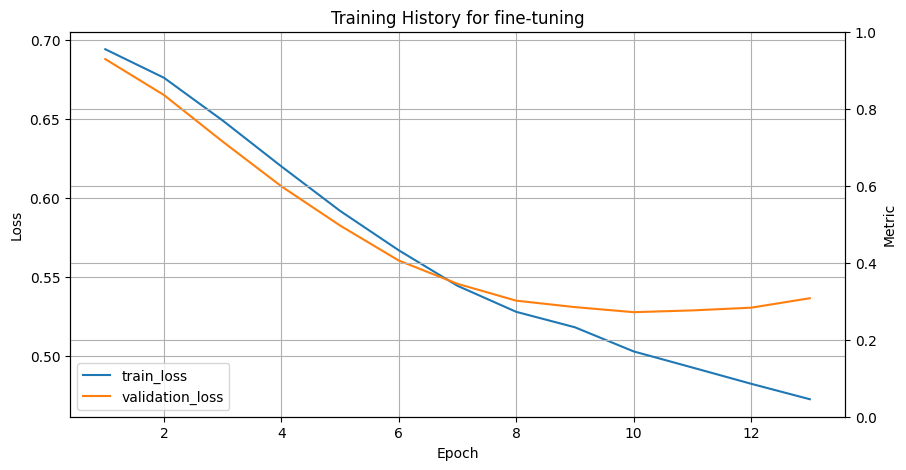

In [15]:
# Get loss, val_loss, and the computed metric from history
loss = [x['loss'] for x in history if 'loss' in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

# Truncate the longer list to the size of the shorter one
min_length = min(len(loss), len(val_loss))
loss = loss[:min_length]
val_loss = val_loss[:min_length]

# Get spearman (for regression) or accuracy value (for classification)
if [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x] != []:
    metric = [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x]
else:
    metric = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]

epochs = [x['epoch'] for x in history if 'loss' in x]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Plot loss and val_loss on the first y-axis
line1 = ax1.plot(epochs, loss, label='train_loss')
line2 = ax1.plot(epochs, val_loss, label='validation_loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot the computed metric on the second y-axis
#line3 = ax2.plot(epochs, metric, color='red', label='validation_metric')
ax2.set_ylabel('Metric')
ax2.set_ylim([0, 1])

# Add grid lines
ax1.grid(True)
ax2.grid(True)

# Combine the lines from both y-axes and create a single legend
lines = line1 + line2 
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')

# Show the plot
plt.title("Training History for fine-tuning")
plt.savefig(f"../Plots/Without_3rdline_Training_History_new.pdf")
plt.show()

dropout_rate 0.24107261119395096

dora_rank 24

dora_init_scale 0.00035088954398140827

In [17]:
def save_model(model,filepath):
# Saves all parameters that were changed during finetuning

    # Create a dictionary to hold the non-frozen parameters
    non_frozen_params = {}

    # Iterate through all the model parameters
    for param_name, param in model.named_parameters():
        # If the parameter has requires_grad=True, add it to the dictionary
        if param.requires_grad:
            non_frozen_params[param_name] = param

    # Save only the finetuned parameters 
    torch.save(non_frozen_params, filepath)

    
def load_model(filepath, num_labels=2):
# Creates a new PT5 model and loads the finetuned weights from a file

    # load a new model
    model, tokenizer = PT5_classification_model(num_labels=num_labels, dropout=0.24107261119395096, dora_rank=24, dora_init_scale=0.00035088954398140827)
    
    # Load the non-frozen parameters from the saved file
    non_frozen_params = torch.load(filepath)

    # Assign the non-frozen parameters to the corresponding parameters of the model
    for param_name, param in model.named_parameters():
        if param_name in non_frozen_params:
            param.data = non_frozen_params[param_name].data

    return tokenizer, model

In [18]:
# tokenizer, model_reload = load_model("../finetuned_model.pth", num_labels=2)
tokenizer, model_reload = load_model("model_output/finetuned_model_all_dora.pth",num_labels=2)

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_DoRA_Classfier
Trainable Parameter: 1200131.0



In [19]:
# Put both models to the same device
model=model.to("cpu")
model_reload=model_reload.to("cpu")

# Iterate through the parameters of the two models and compare the data
for param1, param2 in zip(model.parameters(), model_reload.parameters()):
    if not torch.equal(param1.data, param2.data):
        print("Models have different weights")
        break
else:
    print("Models have identical weights")

Models have identical weights


In [ ]:
# model = from_pretrained("model_output")

In [20]:
from Bio import SeqIO
import pandas as pd

sequences = []

local_fasta_path = '../src/input_datasets/test_Pos_Neg_ST.fasta'

# Load FASTA file using Biopython
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])
    
local_fasta_path = '../src/input_datasets/test_Pos_Neg_Y.fasta'

# Load FASTA file using Biopython
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

# Create dataframe
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display the dataframe
df.head(5)


,name,sequence,label
0,sp|Q8WUI4|HDAC7_HUMAN%342%358,ERLSGSGLHWPLSRTRSEPLPPSATAPPPPGPM,1
1,sp|Q13950|RUNX2_HUMAN%416%432,THYHTYLPPPYPGSSQSQSGPFQTSSTPYLYYG,1
2,sp|Q15796|SMAD2_HUMAN%229%245,DGETSDQQLNQSMDTGSPAELSPTTLSPVNHSL,1
3,sp|P05787|K2C8_HUMAN%416%432,TSGYAGGLSSAYGGLTSPGLSYSLGSSFGSGAG,1
4,sp|Q92736|RYR2_HUMAN%2798%2814,MALYNRTRRISQTSQVSVDAAHGYSPRAIDMSN,1


In [21]:
my_test=df[["sequence", "label"]]

print(my_test.head(5))

'''
my_test["sequence"]=my_test["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
my_test['sequence']=my_test.apply(lambda row : " ".join(row["sequence"]), axis = 1)
'''

#Using .loc ensures that you are modifying the original DataFrame rather than a view of it, which helps avoid the SettingWithCopyWarning.
# Replace characters in the "sequence" column
my_test.loc[:, "sequence"] = my_test["sequence"].str.replace('|'.join(["O", "B", "U", "Z"]), "X", regex=True)

# Convert each sequence to a space-separated string
my_test.loc[:, 'sequence'] = my_test.apply(lambda row: " ".join(row["sequence"]), axis=1)


                            sequence  label
0  ERLSGSGLHWPLSRTRSEPLPPSATAPPPPGPM      1
1  THYHTYLPPPYPGSSQSQSGPFQTSSTPYLYYG      1
2  DGETSDQQLNQSMDTGSPAELSPTTLSPVNHSL      1
3  TSGYAGGLSSAYGGLTSPGLSYSLGSSFGSGAG      1
4  MALYNRTRRISQTSQVSVDAAHGYSPRAIDMSN      1


In [22]:
# Function to get the middle character
def get_middle_char(sequence):
    chars = sequence.split()
    middle_index = len(chars) // 2
    return chars[middle_index]

# Apply the function to get the middle characters
my_test['middle_char'] = my_test['sequence'].apply(get_middle_char)

# Split the DataFrame
my_test_S = my_test[my_test['middle_char'] == 'S'].drop(columns=['middle_char'])
my_test_T = my_test[my_test['middle_char'] == 'T'].drop(columns=['middle_char'])
my_test_Y = my_test[my_test['middle_char'] == 'Y'].drop(columns=['middle_char'])
my_test_ST = my_test[my_test['middle_char'].isin(['S', 'T'])].drop(columns=['middle_char'])

In [23]:
my_test = my_test_Y

In [24]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_auc_score
from tabulate import tabulate

# Set the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_reload.to(device)

# create Dataset
test_set=create_dataset(tokenizer,list(my_test['sequence']),list(my_test['label']))
# make compatible with torch DataLoader
test_set = test_set.with_format("torch", device=device)

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# Put the model in evaluation mode
model_reload.eval()

# Make predictions on the test dataset
raw_logits = []
labels = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # add batch results (logits) to predictions
        raw_logits += model_reload(input_ids, attention_mask=attention_mask).logits.tolist()
        labels += batch["labels"].tolist()

# Convert logits to predictions
raw_logits = np.array(raw_logits)
predictions = np.argmax(raw_logits, axis=1)

# Calculate metrics
conf_matrix = confusion_matrix(labels, predictions)
tn, fp, fn, tp = conf_matrix.ravel()

mcc = matthews_corrcoef(labels, predictions)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy = accuracy_score(labels, predictions)
roc_auc = roc_auc_score(labels, raw_logits[:, 1])  # Assuming binary classification, adjust accordingly


metrics_table = [
    ["MCC", "Specificity", "Sensitivity", "Accuracy", "ROC-AUC"],
    [mcc, specificity, sensitivity, accuracy, roc_auc]
]

print(tabulate(metrics_table, headers="firstrow", tablefmt="grid"))
print(conf_matrix)


100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.48it/s]


+----------+---------------+---------------+------------+-----------+
|      MCC |   Specificity |   Sensitivity |   Accuracy |   ROC-AUC |
+==========+===============+===============+============+===========+
| 0.720577 |      0.846154 |         0.875 |       0.86 |  0.926282 |
+----------+---------------+---------------+------------+-----------+
[[22  4]
 [ 3 21]]


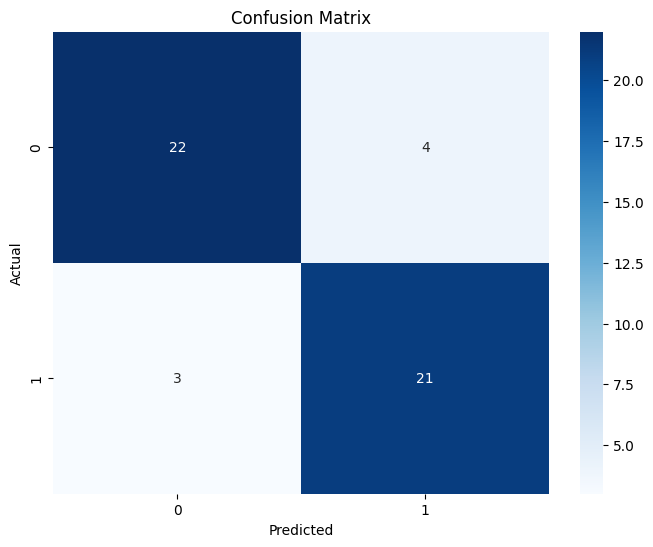

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define class labels
class_labels = ['0', '1']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(f"../Plots/Confusion_matrix_for_dephos_new.pdf")
plt.show()


In [26]:
my_test = my_test_ST

In [27]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_auc_score
from tabulate import tabulate

# Set the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_reload.to(device)

# create Dataset
test_set=create_dataset(tokenizer,list(my_test['sequence']),list(my_test['label']))
# make compatible with torch DataLoader
test_set = test_set.with_format("torch", device=device)

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# Put the model in evaluation mode
model_reload.eval()

# Make predictions on the test dataset
raw_logits = []
labels = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # add batch results (logits) to predictions
        raw_logits += model_reload(input_ids, attention_mask=attention_mask).logits.tolist()
        labels += batch["labels"].tolist()

# Convert logits to predictions
raw_logits = np.array(raw_logits)
predictions = np.argmax(raw_logits, axis=1)

# Calculate metrics
conf_matrix = confusion_matrix(labels, predictions)
tn, fp, fn, tp = conf_matrix.ravel()

mcc = matthews_corrcoef(labels, predictions)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy = accuracy_score(labels, predictions)
roc_auc = roc_auc_score(labels, raw_logits[:, 1])  # Assuming binary classification, adjust accordingly


metrics_table = [
    ["MCC", "Specificity", "Sensitivity", "Accuracy", "ROC-AUC"],
    [mcc, specificity, sensitivity, accuracy, roc_auc]
]

print(tabulate(metrics_table, headers="firstrow", tablefmt="grid"))
print(conf_matrix)


100%|███████████████████████████████████████████████████████████████████████████████| 28/28 [00:03<00:00,  7.43it/s]

+----------+---------------+---------------+------------+-----------+
|      MCC |   Specificity |   Sensitivity |   Accuracy |   ROC-AUC |
+==========+===============+===============+============+===========+
| 0.619497 |      0.834821 |      0.783784 |   0.809417 |  0.865006 |
+----------+---------------+---------------+------------+-----------+
[[187  37]
 [ 48 174]]


In [20]:
import umap

def apply_umap(embeddings, n_components=2, n_neighbors=5, min_dist=0.01, metric='euclidean'):
    umap_model = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric
    )
    umap_embeddings = umap_model.fit_transform(embeddings)
    return umap_embeddings

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_umap(embeddings, labels):
    df = pd.DataFrame({
        "UMAP1": embeddings[:, 0],
        "UMAP2": embeddings[:, 1],
        "Label": labels
    })
    plt.figure(figsize=(10, 8))
    scatter = sns.scatterplot(
        x="UMAP1", y="UMAP2", hue="Label", data=df, palette={0: "blue", 1: "magenta"}, s=50, alpha=0.9
    )
    plt.title("UMAP Visualization of Embeddings")
    plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc=2)
    plt.savefig("../Plots/UMAP_Visualization_of_Embeddings_ST.pdf", bbox_inches='tight')
    plt.show()
    
def get_embeddings(model, tokenizer, sequences, batch_size=32, device="cuda"):
    embeddings = []
    model = model.to(device)
    model.eval()

    for i in range(0, len(sequences), batch_size):
        batch = sequences[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            hidden_states = outputs.hidden_states[-2].detach().cpu().numpy()
            embeddings.extend(hidden_states[:, 0, :])

        print(f"Processed batch {i // batch_size + 1}/{len(sequences) // batch_size + 1}")

    return np.array(embeddings)

In [38]:
# Function to get the middle character
def get_middle_char(sequence):
    chars = list(sequence)
    middle_index = len(chars) // 2
    return chars[middle_index]

valid_df = df

# Apply the function to get the middle characters
valid_df['middle_char'] = valid_df['sequence'].apply(get_middle_char)

valid_df = valid_df[valid_df['middle_char'] == 'T'].drop(columns=['middle_char'])

In [39]:
valid_df

,name,sequence,label
180,sp|Q9GZM8|NDEL1_HUMAN%203%219,CEKMDSAVQASLSLPATPVGKGTENTFPSPKAI,1
181,sp|Q8N163|CCAR2_HUMAN%438%454,EWEALCQQKAAEAAPPTQEAQGETEPTEQAPDA,1
182,sp|P10636-8|TAU_HUMAN%196%212,GYSSPGSPGTPGSRSRTPSLPTPPTREPKKVAV,1
183,sp|Q02241|KIF23_HUMAN%434%450,QEVEVARPVDKAICGLTPGRRYRNQPRGPVGNE,1
184,sp|Q04206|TF65_HUMAN%419%435,QAVAPPAPKPTQAGEGTLSEALLQLQFDDEDLG,1
...,...,...,...
441,sp|Q76N33|STALP_MOUSE%326%342,ENVEELFNVQDQHGLLTLGWIHTHPTQTAFLSS,0
442,sp|P49790|NU153_HUMAN%1098%1114,FVLGRTEEKQQEPVTSTSLVFGKKADNEEPKCQ,0
443,sp|Q8NFC6|BD1L1_HUMAN%2789%2805,DVLDSRIETAQRQCPETEPHDTKEENSRDLEEL,0
444,sp|Q5T6F2|UBAP2_HUMAN%514%530,SKIPASAVEMPGSADVTGLNVQFGALEFGSEPS,0


/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0

Processed batch 1/3
Processed batch 2/3
Processed batch 3/3


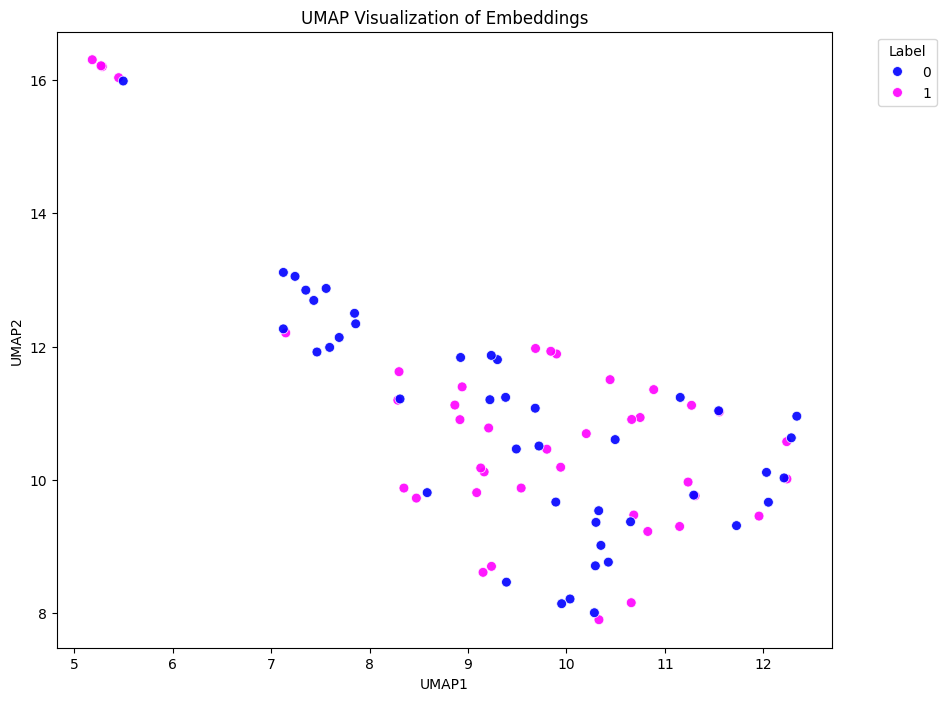

In [40]:
# valid_df = my_valid

# tokenizer, model_reload = load_model("../finetuned_model.pth", num_labels=2)
tokenizer, model_reload = load_model("model_output/finetuned_model_ST.pth",num_labels=2)

valid_df["sequence"] = valid_df["sequence"].str.replace('|'.join(["O", "B", "U", "Z"]), "X", regex=True)
valid_df["sequence"] = valid_df["sequence"].apply(lambda x: " ".join(x))

valid_sequences = list(valid_df['sequence'])
valid_embeddings = get_embeddings(model_reload, tokenizer, valid_sequences)

umap_embeddings = apply_umap(valid_embeddings)


labels = list(valid_df['label'])

plot_umap(umap_embeddings, labels)
